In [1]:
from functools import partial
from typing import Any, Optional

import torch
import torch.nn as nn

from tqdm import tqdm

/home/kuba/miniconda3/envs/sym_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import pandas as pd
import os
from skimage.io import imread
import cv2 as cv
from pathlib import Path
import random
from shutil import copyfile, rmtree
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from torch import nn, optim
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
# root_path = "/content/drive/MyDrive/sw_data/"
root_path = "."

dir = f"{root_path}/train_test_sw/train_sw/"
print(os.listdir(dir))

['Beech', 'Gardenia', 'Lemon', 'Mean', 'Tomato']


In [4]:
test_labels_path = f"{root_path}/train_test_sw/test_labels.json"
test_labels = pd.read_json(test_labels_path)
test_labels["path"] = test_labels.filename.map(
    lambda filename: f"{root_path}/train_test_sw/test_sw/{filename}"
)
test_labels

,filename,value,path
0,Beech1frame0000022.png,Beech,./train_test_sw/test_sw/Beech1frame0000022.png
1,Beech1frame0000026.png,Beech,./train_test_sw/test_sw/Beech1frame0000026.png
2,Beech1frame0000027.png,Beech,./train_test_sw/test_sw/Beech1frame0000027.png
3,Beech1frame0000044.png,Beech,./train_test_sw/test_sw/Beech1frame0000044.png
4,Beech1frame0000045.png,Beech,./train_test_sw/test_sw/Beech1frame0000045.png
...,...,...,...
254,Tomato5frame0000300.png,Tomato,./train_test_sw/test_sw/Tomato5frame0000300.png
255,Tomato5frame0000309.png,Tomato,./train_test_sw/test_sw/Tomato5frame0000309.png
256,Tomato5frame0000311.png,Tomato,./train_test_sw/test_sw/Tomato5frame0000311.png
257,Tomato5frame0000313.png,Tomato,./train_test_sw/test_sw/Tomato5frame0000313.png


In [5]:
train_dirs = os.listdir(f"{root_path}/train_test_sw/train_sw")

train_labels = pd.DataFrame()

for d in train_dirs:
    for f in os.listdir(f"{root_path}/train_test_sw/train_sw/{d}"):
        df_dict = pd.DataFrame(
            [
                {
                    "filename": f,
                    "path": f"{root_path}/train_test_sw/train_sw/{d}/{f}",
                    "value": d,
                }
            ]
        )
        # print(df_dict)
        train_labels = pd.concat([train_labels, df_dict], ignore_index=True)

train_labels


,filename,path,value
0,Beech1frame0000012.png,./train_test_sw/train_sw/Beech/Beech1frame0000...,Beech
1,Beech1frame0000013.png,./train_test_sw/train_sw/Beech/Beech1frame0000...,Beech
2,Beech1frame0000014.png,./train_test_sw/train_sw/Beech/Beech1frame0000...,Beech
3,Beech1frame0000015.png,./train_test_sw/train_sw/Beech/Beech1frame0000...,Beech
4,Beech1frame0000016.png,./train_test_sw/train_sw/Beech/Beech1frame0000...,Beech
...,...,...,...
2870,Tomato5frameModifedModifed0000312.png,./train_test_sw/train_sw/Tomato/Tomato5frameMo...,Tomato
2871,Tomato5frameModifedModifed0000315.png,./train_test_sw/train_sw/Tomato/Tomato5frameMo...,Tomato
2872,Tomato5frameModifedModifed0000316.png,./train_test_sw/train_sw/Tomato/Tomato5frameMo...,Tomato
2873,Tomato5frameModifedModifed0000317.png,./train_test_sw/train_sw/Tomato/Tomato5frameMo...,Tomato


In [6]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [7]:
from torch.utils.data import Dataset
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.img_labels = df["value"]
        self.img_dir = df["path"]
        self.transform = transform
        self.target_transform = target_transform
        self.labels_dict = {label: i for i, label in enumerate(df["value"].unique())}

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_dir[idx]
        image = Image.open(img_path)
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image[:3], self.labels_dict[label]

In [8]:
# Batch size : How many images are used to calculate the gradient
batch_size = 32
number_of_classes = 5
# Train DataLoader
train_dataset = CustomImageDataset(
    train_labels,
    transform=transforms.Compose(
        [
            transforms.Resize(64),
            # transforms.Normalize(),
            transforms.ToTensor(),
        ]
    ),
)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# Validation DataLoader
validation_dataset = CustomImageDataset(
    test_labels,
    transform=transforms.Compose(
        [
            transforms.Resize(64),
            # transforms.Normalize(),
            transforms.ToTensor(),
        ]
    ),
)
validation_loader = DataLoader(
    dataset=validation_dataset, batch_size=batch_size, shuffle=False
)

In [9]:
device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
device

device(type='cuda', index=0)

In [10]:
num_classes = 5
num_epochs = 100
batch_size = 32
learning_rate = 0.0009

# model = AlexNet().to(device)




In [11]:
train_acc = []
train_loss = []

def train(epoch):
  print('\nEpoch : %d'%epoch)
   
  model.train()
 
  running_loss=0
  correct=0
  total=0

  for i, (imgs, labels) in enumerate(tqdm(train_loader, leave=False)):
    #move tensors to device
    imgs = imgs.to(device)
    labels = labels.to(device)

    #Forward pass
    outputs = model(imgs)
    loss = criterion(outputs, labels)

    #Bacward & opt
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    #
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

  loss = running_loss/len(train_loader)
  acc = correct/total

  train_acc.append(acc)
  train_loss.append(loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(loss, acc))

  scheduler.step()

In [12]:
eval_loss = []
eval_acc = []
 
def test(epoch):
  model.eval()
 
  running_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for imgs, labels in tqdm(validation_loader, leave=False):
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs)

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
      del imgs, labels, outputs
    
  test_loss = running_loss/len(validation_loader)
  acc = correct/total

  eval_loss.append(test_loss)
  eval_acc.append(acc)
 
  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,acc))

In [14]:
num_epochs = 100
for epoch in range(num_epochs): 
  train(epoch)
  test(epoch)


Epoch : 0


100%|██████████| 90/90 [00:25<00:00,  3.49it/s]


Train Loss: 2.256 | Accuracy: 0.201


100%|██████████| 9/9 [00:02<00:00,  3.44it/s]


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 1


100%|██████████| 90/90 [00:22<00:00,  3.91it/s]


Train Loss: 1.614 | Accuracy: 0.216


100%|██████████| 9/9 [00:02<00:00,  3.46it/s]


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 2


100%|██████████| 90/90 [00:22<00:00,  3.91it/s]


Train Loss: 1.609 | Accuracy: 0.214


100%|██████████| 9/9 [00:02<00:00,  3.11it/s]


Test Loss: 0.000 | Accuracy: 0.309

Epoch : 3


100%|██████████| 90/90 [00:23<00:00,  3.78it/s]


Train Loss: 1.544 | Accuracy: 0.258


100%|██████████| 9/9 [00:02<00:00,  3.69it/s]


Test Loss: 0.000 | Accuracy: 0.402

Epoch : 4


100%|██████████| 90/90 [00:24<00:00,  3.72it/s]


Train Loss: 1.544 | Accuracy: 0.278


100%|██████████| 9/9 [00:02<00:00,  3.62it/s]


Test Loss: 0.000 | Accuracy: 0.212

Epoch : 5


100%|██████████| 90/90 [00:23<00:00,  3.79it/s]


Train Loss: 1.457 | Accuracy: 0.299


100%|██████████| 9/9 [00:02<00:00,  3.27it/s]


Test Loss: 0.000 | Accuracy: 0.602

Epoch : 6


100%|██████████| 90/90 [00:23<00:00,  3.78it/s]


Train Loss: 1.343 | Accuracy: 0.373


100%|██████████| 9/9 [00:02<00:00,  3.50it/s]


Test Loss: 0.000 | Accuracy: 0.606

Epoch : 7


100%|██████████| 90/90 [00:22<00:00,  4.04it/s]


Train Loss: 1.277 | Accuracy: 0.397


100%|██████████| 9/9 [00:02<00:00,  3.57it/s]


Test Loss: 0.000 | Accuracy: 0.625

Epoch : 8


100%|██████████| 90/90 [00:22<00:00,  4.00it/s]


Train Loss: 1.238 | Accuracy: 0.410


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Test Loss: 0.000 | Accuracy: 0.633

Epoch : 9


100%|██████████| 90/90 [00:19<00:00,  4.50it/s]


Train Loss: 1.209 | Accuracy: 0.427


100%|██████████| 9/9 [00:02<00:00,  4.13it/s]


Test Loss: 0.000 | Accuracy: 0.668

Epoch : 10


100%|██████████| 90/90 [00:19<00:00,  4.60it/s]


Train Loss: 1.390 | Accuracy: 0.363


100%|██████████| 9/9 [00:02<00:00,  4.30it/s]


Test Loss: 0.000 | Accuracy: 0.471

Epoch : 11


100%|██████████| 90/90 [00:18<00:00,  4.79it/s]


Train Loss: 1.453 | Accuracy: 0.330


100%|██████████| 9/9 [00:02<00:00,  4.35it/s]


Test Loss: 0.000 | Accuracy: 0.413

Epoch : 12


100%|██████████| 90/90 [00:19<00:00,  4.66it/s]


Train Loss: 1.431 | Accuracy: 0.335


100%|██████████| 9/9 [00:02<00:00,  4.33it/s]


Test Loss: 0.000 | Accuracy: 0.432

Epoch : 13


100%|██████████| 90/90 [00:19<00:00,  4.65it/s]


Train Loss: 1.385 | Accuracy: 0.367


100%|██████████| 9/9 [00:02<00:00,  4.07it/s]


Test Loss: 0.000 | Accuracy: 0.514

Epoch : 14


100%|██████████| 90/90 [00:18<00:00,  4.81it/s]


Train Loss: 1.278 | Accuracy: 0.390


100%|██████████| 9/9 [00:02<00:00,  4.09it/s]


Test Loss: 0.000 | Accuracy: 0.618

Epoch : 15


100%|██████████| 90/90 [00:19<00:00,  4.64it/s]


Train Loss: 1.217 | Accuracy: 0.422


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Test Loss: 0.000 | Accuracy: 0.641

Epoch : 16


100%|██████████| 90/90 [00:19<00:00,  4.55it/s]


Train Loss: 1.160 | Accuracy: 0.455


100%|██████████| 9/9 [00:02<00:00,  4.29it/s]


Test Loss: 0.000 | Accuracy: 0.730

Epoch : 17


100%|██████████| 90/90 [00:19<00:00,  4.70it/s]


Train Loss: 1.097 | Accuracy: 0.473


100%|██████████| 9/9 [00:02<00:00,  4.40it/s]


Test Loss: 0.000 | Accuracy: 0.757

Epoch : 18


100%|██████████| 90/90 [00:18<00:00,  4.77it/s]


Train Loss: 1.052 | Accuracy: 0.509


100%|██████████| 9/9 [00:02<00:00,  4.19it/s]


Test Loss: 0.000 | Accuracy: 0.776

Epoch : 19


100%|██████████| 90/90 [00:19<00:00,  4.57it/s]


Train Loss: 1.018 | Accuracy: 0.541


100%|██████████| 9/9 [00:02<00:00,  3.91it/s]


Test Loss: 0.000 | Accuracy: 0.792

Epoch : 20


100%|██████████| 90/90 [00:18<00:00,  4.89it/s]


Train Loss: 1.239 | Accuracy: 0.414


100%|██████████| 9/9 [00:02<00:00,  4.24it/s]


Test Loss: 0.000 | Accuracy: 0.680

Epoch : 21


100%|██████████| 90/90 [00:19<00:00,  4.52it/s]


Train Loss: 1.264 | Accuracy: 0.419


100%|██████████| 9/9 [00:02<00:00,  4.26it/s]


Test Loss: 0.000 | Accuracy: 0.745

Epoch : 22


100%|██████████| 90/90 [00:19<00:00,  4.54it/s]


Train Loss: 1.236 | Accuracy: 0.412


100%|██████████| 9/9 [00:02<00:00,  4.31it/s]


Test Loss: 0.000 | Accuracy: 0.641

Epoch : 23


100%|██████████| 90/90 [00:18<00:00,  4.78it/s]


Train Loss: 1.173 | Accuracy: 0.451


100%|██████████| 9/9 [00:02<00:00,  4.46it/s]


Test Loss: 0.000 | Accuracy: 0.568

Epoch : 24


100%|██████████| 90/90 [00:18<00:00,  4.75it/s]


Train Loss: 1.158 | Accuracy: 0.457


100%|██████████| 9/9 [00:02<00:00,  4.35it/s]


Test Loss: 0.000 | Accuracy: 0.645

Epoch : 25


100%|██████████| 90/90 [00:18<00:00,  4.84it/s]


Train Loss: 1.124 | Accuracy: 0.475


100%|██████████| 9/9 [00:02<00:00,  4.43it/s]


Test Loss: 0.000 | Accuracy: 0.776

Epoch : 26


100%|██████████| 90/90 [00:19<00:00,  4.65it/s]


Train Loss: 1.054 | Accuracy: 0.494


100%|██████████| 9/9 [00:02<00:00,  4.27it/s]


Test Loss: 0.000 | Accuracy: 0.722

Epoch : 27


100%|██████████| 90/90 [00:19<00:00,  4.60it/s]


Train Loss: 1.025 | Accuracy: 0.515


100%|██████████| 9/9 [00:02<00:00,  4.38it/s]


Test Loss: 0.000 | Accuracy: 0.826

Epoch : 28


100%|██████████| 90/90 [00:18<00:00,  4.86it/s]


Train Loss: 0.987 | Accuracy: 0.528


100%|██████████| 9/9 [00:02<00:00,  4.33it/s]


Test Loss: 0.000 | Accuracy: 0.826

Epoch : 29


100%|██████████| 90/90 [00:18<00:00,  4.83it/s]


Train Loss: 0.969 | Accuracy: 0.536


100%|██████████| 9/9 [00:02<00:00,  4.35it/s]


Test Loss: 0.000 | Accuracy: 0.830

Epoch : 30


100%|██████████| 90/90 [00:19<00:00,  4.70it/s]


Train Loss: 1.215 | Accuracy: 0.453


100%|██████████| 9/9 [00:02<00:00,  4.39it/s]


Test Loss: 0.000 | Accuracy: 0.579

Epoch : 31


100%|██████████| 90/90 [00:18<00:00,  4.76it/s]


Train Loss: 1.260 | Accuracy: 0.416


100%|██████████| 9/9 [00:02<00:00,  4.30it/s]


Test Loss: 0.000 | Accuracy: 0.714

Epoch : 32


100%|██████████| 90/90 [00:19<00:00,  4.54it/s]


Train Loss: 1.151 | Accuracy: 0.447


100%|██████████| 9/9 [00:02<00:00,  4.18it/s]


Test Loss: 0.000 | Accuracy: 0.749

Epoch : 33


100%|██████████| 90/90 [00:18<00:00,  4.88it/s]


Train Loss: 1.102 | Accuracy: 0.469


100%|██████████| 9/9 [00:02<00:00,  4.30it/s]


Test Loss: 0.000 | Accuracy: 0.784

Epoch : 34


100%|██████████| 90/90 [00:20<00:00,  4.46it/s]


Train Loss: 1.070 | Accuracy: 0.493


100%|██████████| 9/9 [00:02<00:00,  3.62it/s]


Test Loss: 0.000 | Accuracy: 0.792

Epoch : 35


100%|██████████| 90/90 [00:21<00:00,  4.19it/s]


Train Loss: 1.023 | Accuracy: 0.517


100%|██████████| 9/9 [00:02<00:00,  4.20it/s]


Test Loss: 0.000 | Accuracy: 0.830

Epoch : 36


100%|██████████| 90/90 [00:19<00:00,  4.71it/s]


Train Loss: 0.989 | Accuracy: 0.535


100%|██████████| 9/9 [00:02<00:00,  4.34it/s]


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 37


100%|██████████| 90/90 [00:18<00:00,  4.75it/s]


Train Loss: 0.954 | Accuracy: 0.546


100%|██████████| 9/9 [00:02<00:00,  4.31it/s]


Test Loss: 0.000 | Accuracy: 0.838

Epoch : 38


100%|██████████| 90/90 [00:19<00:00,  4.66it/s]


Train Loss: 0.944 | Accuracy: 0.557


100%|██████████| 9/9 [00:02<00:00,  4.31it/s]


Test Loss: 0.000 | Accuracy: 0.842

Epoch : 39


100%|██████████| 90/90 [00:19<00:00,  4.63it/s]


Train Loss: 0.926 | Accuracy: 0.560


100%|██████████| 9/9 [00:02<00:00,  4.44it/s]


Test Loss: 0.000 | Accuracy: 0.834

Epoch : 40


100%|██████████| 90/90 [00:19<00:00,  4.55it/s]


Train Loss: 1.062 | Accuracy: 0.498


100%|██████████| 9/9 [00:02<00:00,  4.44it/s]


Test Loss: 0.000 | Accuracy: 0.745

Epoch : 41


100%|██████████| 90/90 [00:19<00:00,  4.64it/s]


Train Loss: 1.067 | Accuracy: 0.495


100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


Test Loss: 0.000 | Accuracy: 0.834

Epoch : 42


100%|██████████| 90/90 [00:19<00:00,  4.70it/s]


Train Loss: 1.029 | Accuracy: 0.503


100%|██████████| 9/9 [00:02<00:00,  4.31it/s]


Test Loss: 0.000 | Accuracy: 0.822

Epoch : 43


100%|██████████| 90/90 [00:21<00:00,  4.13it/s]


Train Loss: 0.997 | Accuracy: 0.531


100%|██████████| 9/9 [00:02<00:00,  3.50it/s]


Test Loss: 0.000 | Accuracy: 0.730

Epoch : 44


100%|██████████| 90/90 [00:19<00:00,  4.51it/s]


Train Loss: 0.967 | Accuracy: 0.552


100%|██████████| 9/9 [00:02<00:00,  3.94it/s]


Test Loss: 0.000 | Accuracy: 0.815

Epoch : 45


100%|██████████| 90/90 [00:17<00:00,  5.05it/s]


Train Loss: 0.943 | Accuracy: 0.558


100%|██████████| 9/9 [00:02<00:00,  4.32it/s]


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 46


100%|██████████| 90/90 [00:19<00:00,  4.56it/s]


Train Loss: 0.899 | Accuracy: 0.574


100%|██████████| 9/9 [00:02<00:00,  4.07it/s]


Test Loss: 0.000 | Accuracy: 0.846

Epoch : 47


100%|██████████| 90/90 [00:19<00:00,  4.55it/s]


Train Loss: 0.855 | Accuracy: 0.593


100%|██████████| 9/9 [00:02<00:00,  4.08it/s]


Test Loss: 0.000 | Accuracy: 0.846

Epoch : 48


100%|██████████| 90/90 [00:19<00:00,  4.70it/s]


Train Loss: 0.841 | Accuracy: 0.606


100%|██████████| 9/9 [00:02<00:00,  4.27it/s]


Test Loss: 0.000 | Accuracy: 0.869

Epoch : 49


100%|██████████| 90/90 [00:17<00:00,  5.01it/s]


Train Loss: 0.818 | Accuracy: 0.611


100%|██████████| 9/9 [00:02<00:00,  4.48it/s]


Test Loss: 0.000 | Accuracy: 0.873

Epoch : 50


100%|██████████| 90/90 [00:19<00:00,  4.67it/s]


Train Loss: 1.001 | Accuracy: 0.539


100%|██████████| 9/9 [00:02<00:00,  4.13it/s]


Test Loss: 0.000 | Accuracy: 0.672

Epoch : 51


100%|██████████| 90/90 [00:20<00:00,  4.31it/s]


Train Loss: 1.071 | Accuracy: 0.506


100%|██████████| 9/9 [00:02<00:00,  3.59it/s]


Test Loss: 0.000 | Accuracy: 0.803

Epoch : 52


100%|██████████| 90/90 [00:21<00:00,  4.28it/s]


Train Loss: 1.088 | Accuracy: 0.506


100%|██████████| 9/9 [00:02<00:00,  3.81it/s]


Test Loss: 0.000 | Accuracy: 0.753

Epoch : 53


100%|██████████| 90/90 [00:22<00:00,  4.02it/s]


Train Loss: 1.094 | Accuracy: 0.486


100%|██████████| 9/9 [00:02<00:00,  3.66it/s]


Test Loss: 0.000 | Accuracy: 0.838

Epoch : 54


100%|██████████| 90/90 [00:22<00:00,  3.93it/s]


Train Loss: 0.964 | Accuracy: 0.549


100%|██████████| 9/9 [00:02<00:00,  3.23it/s]


Test Loss: 0.000 | Accuracy: 0.822

Epoch : 55


100%|██████████| 90/90 [00:21<00:00,  4.16it/s]


Train Loss: 0.924 | Accuracy: 0.560


100%|██████████| 9/9 [00:02<00:00,  3.60it/s]


Test Loss: 0.000 | Accuracy: 0.857

Epoch : 56


100%|██████████| 90/90 [00:21<00:00,  4.23it/s]


Train Loss: 0.873 | Accuracy: 0.589


100%|██████████| 9/9 [00:02<00:00,  3.64it/s]


Test Loss: 0.000 | Accuracy: 0.880

Epoch : 57


100%|██████████| 90/90 [00:19<00:00,  4.71it/s]


Train Loss: 0.839 | Accuracy: 0.605


100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 58


100%|██████████| 90/90 [00:19<00:00,  4.65it/s]


Train Loss: 0.818 | Accuracy: 0.614


100%|██████████| 9/9 [00:02<00:00,  4.35it/s]


Test Loss: 0.000 | Accuracy: 0.869

Epoch : 59


100%|██████████| 90/90 [00:19<00:00,  4.66it/s]


Train Loss: 0.811 | Accuracy: 0.617


100%|██████████| 9/9 [00:02<00:00,  3.57it/s]


Test Loss: 0.000 | Accuracy: 0.869

Epoch : 60


100%|██████████| 90/90 [00:18<00:00,  4.89it/s]


Train Loss: 0.960 | Accuracy: 0.555


100%|██████████| 9/9 [00:02<00:00,  4.36it/s]


Test Loss: 0.000 | Accuracy: 0.772

Epoch : 61


100%|██████████| 90/90 [00:19<00:00,  4.62it/s]


Train Loss: 1.008 | Accuracy: 0.538


100%|██████████| 9/9 [00:02<00:00,  3.68it/s]


Test Loss: 0.000 | Accuracy: 0.764

Epoch : 62


100%|██████████| 90/90 [00:21<00:00,  4.16it/s]


Train Loss: 0.916 | Accuracy: 0.563


100%|██████████| 9/9 [00:02<00:00,  3.67it/s]


Test Loss: 0.000 | Accuracy: 0.834

Epoch : 63


100%|██████████| 90/90 [00:21<00:00,  4.15it/s]


Train Loss: 0.882 | Accuracy: 0.588


100%|██████████| 9/9 [00:02<00:00,  3.31it/s]


Test Loss: 0.000 | Accuracy: 0.822

Epoch : 64


100%|██████████| 90/90 [00:21<00:00,  4.22it/s]


Train Loss: 0.839 | Accuracy: 0.610


100%|██████████| 9/9 [00:02<00:00,  3.73it/s]


Test Loss: 0.000 | Accuracy: 0.838

Epoch : 65


100%|██████████| 90/90 [00:21<00:00,  4.18it/s]


Train Loss: 0.812 | Accuracy: 0.613


100%|██████████| 9/9 [00:02<00:00,  3.25it/s]


Test Loss: 0.000 | Accuracy: 0.842

Epoch : 66


100%|██████████| 90/90 [00:23<00:00,  3.91it/s]


Train Loss: 0.779 | Accuracy: 0.634


100%|██████████| 9/9 [00:02<00:00,  3.56it/s]


Test Loss: 0.000 | Accuracy: 0.830

Epoch : 67


100%|██████████| 90/90 [00:21<00:00,  4.12it/s]


Train Loss: 0.764 | Accuracy: 0.638


100%|██████████| 9/9 [00:02<00:00,  3.25it/s]


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 68


100%|██████████| 90/90 [00:22<00:00,  4.01it/s]


Train Loss: 0.747 | Accuracy: 0.647


100%|██████████| 9/9 [00:02<00:00,  3.35it/s]


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 69


100%|██████████| 90/90 [00:22<00:00,  4.08it/s]


Train Loss: 0.738 | Accuracy: 0.655


100%|██████████| 9/9 [00:02<00:00,  3.27it/s]


Test Loss: 0.000 | Accuracy: 0.842

Epoch : 70


100%|██████████| 90/90 [00:20<00:00,  4.35it/s]


Train Loss: 0.863 | Accuracy: 0.606


100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


Test Loss: 0.000 | Accuracy: 0.784

Epoch : 71


100%|██████████| 90/90 [00:18<00:00,  4.86it/s]


Train Loss: 0.887 | Accuracy: 0.591


100%|██████████| 9/9 [00:02<00:00,  4.32it/s]


Test Loss: 0.000 | Accuracy: 0.838

Epoch : 72


100%|██████████| 90/90 [00:19<00:00,  4.65it/s]


Train Loss: 0.840 | Accuracy: 0.618


100%|██████████| 9/9 [00:02<00:00,  4.28it/s]


Test Loss: 0.000 | Accuracy: 0.811

Epoch : 73


100%|██████████| 90/90 [00:19<00:00,  4.72it/s]


Train Loss: 0.807 | Accuracy: 0.626


100%|██████████| 9/9 [00:02<00:00,  4.34it/s]


Test Loss: 0.000 | Accuracy: 0.842

Epoch : 74


100%|██████████| 90/90 [00:19<00:00,  4.70it/s]


Train Loss: 0.799 | Accuracy: 0.616


100%|██████████| 9/9 [00:02<00:00,  4.36it/s]


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 75


100%|██████████| 90/90 [00:20<00:00,  4.48it/s]


Train Loss: 0.760 | Accuracy: 0.643


100%|██████████| 9/9 [00:02<00:00,  3.55it/s]


Test Loss: 0.000 | Accuracy: 0.857

Epoch : 76


100%|██████████| 90/90 [00:19<00:00,  4.56it/s]


Train Loss: 0.733 | Accuracy: 0.650


100%|██████████| 9/9 [00:02<00:00,  3.96it/s]


Test Loss: 0.000 | Accuracy: 0.861

Epoch : 77


100%|██████████| 90/90 [00:20<00:00,  4.34it/s]


Train Loss: 0.697 | Accuracy: 0.670


100%|██████████| 9/9 [00:02<00:00,  3.71it/s]


Test Loss: 0.000 | Accuracy: 0.861

Epoch : 78


100%|██████████| 90/90 [00:20<00:00,  4.35it/s]


Train Loss: 0.679 | Accuracy: 0.686


100%|██████████| 9/9 [00:02<00:00,  3.77it/s]


Test Loss: 0.000 | Accuracy: 0.861

Epoch : 79


100%|██████████| 90/90 [00:21<00:00,  4.23it/s]


Train Loss: 0.672 | Accuracy: 0.683


100%|██████████| 9/9 [00:02<00:00,  3.74it/s]


Test Loss: 0.000 | Accuracy: 0.861

Epoch : 80


100%|██████████| 90/90 [00:20<00:00,  4.49it/s]


Train Loss: 0.818 | Accuracy: 0.613


100%|██████████| 9/9 [00:02<00:00,  3.79it/s]


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 81


100%|██████████| 90/90 [00:21<00:00,  4.15it/s]


Train Loss: 1.053 | Accuracy: 0.558


100%|██████████| 9/9 [00:02<00:00,  3.71it/s]


Test Loss: 0.000 | Accuracy: 0.722

Epoch : 82


100%|██████████| 90/90 [00:22<00:00,  3.98it/s]


Train Loss: 0.911 | Accuracy: 0.599


100%|██████████| 9/9 [00:02<00:00,  3.60it/s]


Test Loss: 0.000 | Accuracy: 0.807

Epoch : 83


100%|██████████| 90/90 [00:21<00:00,  4.24it/s]


Train Loss: 0.816 | Accuracy: 0.626


100%|██████████| 9/9 [00:02<00:00,  3.32it/s]


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 84


100%|██████████| 90/90 [00:20<00:00,  4.48it/s]


Train Loss: 0.745 | Accuracy: 0.654


100%|██████████| 9/9 [00:02<00:00,  4.30it/s]


Test Loss: 0.000 | Accuracy: 0.834

Epoch : 85


100%|██████████| 90/90 [00:19<00:00,  4.57it/s]


Train Loss: 0.736 | Accuracy: 0.658


100%|██████████| 9/9 [00:02<00:00,  4.25it/s]


Test Loss: 0.000 | Accuracy: 0.865

Epoch : 86


100%|██████████| 90/90 [00:20<00:00,  4.31it/s]


Train Loss: 0.675 | Accuracy: 0.689


100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Test Loss: 0.000 | Accuracy: 0.873

Epoch : 87


100%|██████████| 90/90 [00:19<00:00,  4.73it/s]


Train Loss: 0.652 | Accuracy: 0.697


100%|██████████| 9/9 [00:02<00:00,  3.69it/s]


Test Loss: 0.000 | Accuracy: 0.873

Epoch : 88


100%|██████████| 90/90 [00:20<00:00,  4.36it/s]


Train Loss: 0.639 | Accuracy: 0.704


100%|██████████| 9/9 [00:02<00:00,  3.30it/s]


Test Loss: 0.000 | Accuracy: 0.876

Epoch : 89


100%|██████████| 90/90 [00:24<00:00,  3.72it/s]


Train Loss: 0.629 | Accuracy: 0.709


100%|██████████| 9/9 [00:02<00:00,  3.54it/s]


Test Loss: 0.000 | Accuracy: 0.880

Epoch : 90


100%|██████████| 90/90 [00:22<00:00,  4.05it/s]


Train Loss: 0.761 | Accuracy: 0.637


100%|██████████| 9/9 [00:02<00:00,  4.11it/s]


Test Loss: 0.000 | Accuracy: 0.865

Epoch : 91


100%|██████████| 90/90 [00:19<00:00,  4.58it/s]


Train Loss: 0.925 | Accuracy: 0.586


100%|██████████| 9/9 [00:02<00:00,  3.87it/s]


Test Loss: 0.000 | Accuracy: 0.784

Epoch : 92


100%|██████████| 90/90 [00:19<00:00,  4.71it/s]


Train Loss: 0.793 | Accuracy: 0.640


100%|██████████| 9/9 [00:02<00:00,  4.35it/s]


Test Loss: 0.000 | Accuracy: 0.846

Epoch : 93


100%|██████████| 90/90 [00:19<00:00,  4.72it/s]


Train Loss: 0.732 | Accuracy: 0.658


100%|██████████| 9/9 [00:02<00:00,  4.24it/s]


Test Loss: 0.000 | Accuracy: 0.834

Epoch : 94


100%|██████████| 90/90 [00:19<00:00,  4.54it/s]


Train Loss: 0.859 | Accuracy: 0.620


100%|██████████| 9/9 [00:02<00:00,  4.31it/s]


Test Loss: 0.000 | Accuracy: 0.869

Epoch : 95


100%|██████████| 90/90 [00:19<00:00,  4.69it/s]


Train Loss: 0.727 | Accuracy: 0.666


100%|██████████| 9/9 [00:02<00:00,  4.24it/s]


Test Loss: 0.000 | Accuracy: 0.880

Epoch : 96


100%|██████████| 90/90 [00:18<00:00,  4.84it/s]


Train Loss: 0.659 | Accuracy: 0.687


100%|██████████| 9/9 [00:02<00:00,  4.33it/s]


Test Loss: 0.000 | Accuracy: 0.873

Epoch : 97


100%|██████████| 90/90 [00:19<00:00,  4.56it/s]


Train Loss: 0.629 | Accuracy: 0.707


100%|██████████| 9/9 [00:02<00:00,  4.39it/s]


Test Loss: 0.000 | Accuracy: 0.869

Epoch : 98


100%|██████████| 90/90 [00:19<00:00,  4.56it/s]


Train Loss: 0.616 | Accuracy: 0.725


100%|██████████| 9/9 [00:02<00:00,  4.32it/s]


Test Loss: 0.000 | Accuracy: 0.869

Epoch : 99


100%|██████████| 90/90 [00:19<00:00,  4.62it/s]


Train Loss: 0.603 | Accuracy: 0.722


100%|██████████| 9/9 [00:02<00:00,  4.25it/s]

Test Loss: 0.000 | Accuracy: 0.876


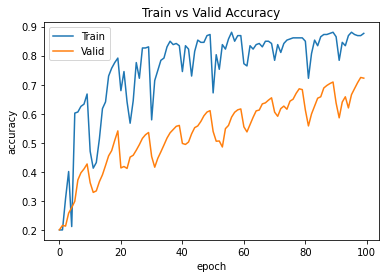

In [17]:
plt.plot(eval_acc)
plt.plot(train_acc)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

In [13]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.25, drop_flat: bool = False, drop_pool: bool = False, drop_conv: bool = False) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential()
        if(drop_flat): self.classifier.add_module("Dropout_flat", nn.Dropout(p=dropout))
        self.classifier.add_module("Liear1", nn.Linear(256 * 6 * 6, 4096))
        self.classifier.add_module("ReLU1",nn.ReLU(inplace=True))
        if(drop_pool): self.classifier.add_module("Dropout_pool", nn.Dropout(p=dropout))
        self.classifier.add_module("Linear2", nn.Linear(4096, 4096))
        self.classifier.add_module("ReLU2", nn.ReLU(inplace=True))
        if(drop_conv): self.classifier.add_module("Dropout_conv",nn.Dropout(p=dropout))
        self.classifier.add_module("Linear3", nn.Linear(4096, num_classes))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

7
Sequential(
  (Dropout_flat): Dropout(p=0.25, inplace=False)
  (Liear1): Linear(in_features=9216, out_features=4096, bias=True)
  (ReLU1): ReLU(inplace=True)
  (Dropout_pool): Dropout(p=0.25, inplace=False)
  (Linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (ReLU2): ReLU(inplace=True)
  (Dropout_conv): Dropout(p=0.25, inplace=False)
  (Linear3): Linear(in_features=4096, out_features=1000, bias=True)
)

Epoch : 0


Train Loss: 2.139 | Accuracy: 0.206


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 1


Train Loss: 1.620 | Accuracy: 0.198


Test Loss: 0.000 | Accuracy: 0.197

Epoch : 2


Train Loss: 1.614 | Accuracy: 0.226


Test Loss: 0.000 | Accuracy: 0.278

Epoch : 3


Train Loss: 1.589 | Accuracy: 0.263


Test Loss: 0.000 | Accuracy: 0.239

Epoch : 4


Train Loss: 1.548 | Accuracy: 0.247


Test Loss: 0.000 | Accuracy: 0.317

Epoch : 5


Train Loss: 1.503 | Accuracy: 0.292


Test Loss: 0.000 | Accuracy: 0.471

Epoch : 6


Train Loss: 1.405 | Accuracy: 0.334


Test Loss: 0.000 | Accuracy: 0.510

Epoch : 7


Train Loss: 1.329 | Accuracy: 0.359


Test Loss: 0.000 | Accuracy: 0.560

Epoch : 8


Train Loss: 1.290 | Accuracy: 0.402


Test Loss: 0.000 | Accuracy: 0.598

Epoch : 9


Train Loss: 1.244 | Accuracy: 0.412


Test Loss: 0.000 | Accuracy: 0.649

Epoch : 10


Train Loss: 1.398 | Accuracy: 0.341


Test Loss: 0.000 | Accuracy: 0.537

Epoch : 11


Train Loss: 1.397 | Accuracy: 0.352


Test Loss: 0.000 | Accuracy: 0.564

Epoch : 12


Train Loss: 1.361 | Accuracy: 0.361


Test Loss: 0.000 | Accuracy: 0.529

Epoch : 13


Train Loss: 1.315 | Accuracy: 0.381


Test Loss: 0.000 | Accuracy: 0.676

Epoch : 14


Train Loss: 1.246 | Accuracy: 0.395


Test Loss: 0.000 | Accuracy: 0.691

Epoch : 15


Train Loss: 1.185 | Accuracy: 0.449


Test Loss: 0.000 | Accuracy: 0.749

Epoch : 16


Train Loss: 1.140 | Accuracy: 0.452


Test Loss: 0.000 | Accuracy: 0.761

Epoch : 17


Train Loss: 1.089 | Accuracy: 0.471


Test Loss: 0.000 | Accuracy: 0.780

Epoch : 18


Train Loss: 1.052 | Accuracy: 0.491


Test Loss: 0.000 | Accuracy: 0.819

Epoch : 19


Train Loss: 1.032 | Accuracy: 0.506


Test Loss: 0.000 | Accuracy: 0.819

Epoch : 20


Train Loss: 1.235 | Accuracy: 0.419


Test Loss: 0.000 | Accuracy: 0.629

Epoch : 21


Train Loss: 1.261 | Accuracy: 0.414


Test Loss: 0.000 | Accuracy: 0.737

Epoch : 22


Train Loss: 1.227 | Accuracy: 0.430


Test Loss: 0.000 | Accuracy: 0.695

Epoch : 23


Train Loss: 1.242 | Accuracy: 0.417


Test Loss: 0.000 | Accuracy: 0.753

Epoch : 24


Train Loss: 1.119 | Accuracy: 0.472


Test Loss: 0.000 | Accuracy: 0.815

Epoch : 25


Train Loss: 1.064 | Accuracy: 0.508


Test Loss: 0.000 | Accuracy: 0.826

Epoch : 26


Train Loss: 1.030 | Accuracy: 0.524


Test Loss: 0.000 | Accuracy: 0.803

Epoch : 27


Train Loss: 0.964 | Accuracy: 0.552


Test Loss: 0.000 | Accuracy: 0.807

Epoch : 28


Train Loss: 0.924 | Accuracy: 0.559


Test Loss: 0.000 | Accuracy: 0.830

Epoch : 29


Train Loss: 0.877 | Accuracy: 0.594


Test Loss: 0.000 | Accuracy: 0.830

Epoch : 30


Train Loss: 1.165 | Accuracy: 0.462


Test Loss: 0.000 | Accuracy: 0.757

Epoch : 31


Train Loss: 1.169 | Accuracy: 0.463


Test Loss: 0.000 | Accuracy: 0.714

Epoch : 32


Train Loss: 1.083 | Accuracy: 0.501


Test Loss: 0.000 | Accuracy: 0.780

Epoch : 33


Train Loss: 1.015 | Accuracy: 0.534


Test Loss: 0.000 | Accuracy: 0.799

Epoch : 34


Train Loss: 0.983 | Accuracy: 0.552


Test Loss: 0.000 | Accuracy: 0.799

Epoch : 35


Train Loss: 0.908 | Accuracy: 0.581


Test Loss: 0.000 | Accuracy: 0.857

Epoch : 36


Train Loss: 0.848 | Accuracy: 0.601


Test Loss: 0.000 | Accuracy: 0.876

Epoch : 37


Train Loss: 0.806 | Accuracy: 0.623


Test Loss: 0.000 | Accuracy: 0.876

Epoch : 38


Train Loss: 0.777 | Accuracy: 0.637


Test Loss: 0.000 | Accuracy: 0.892

Epoch : 39


Train Loss: 0.750 | Accuracy: 0.650


Test Loss: 0.000 | Accuracy: 0.892

Epoch : 40


Train Loss: 0.961 | Accuracy: 0.560


Test Loss: 0.000 | Accuracy: 0.819

Epoch : 41


Train Loss: 1.060 | Accuracy: 0.527


Test Loss: 0.000 | Accuracy: 0.834

Epoch : 42


Train Loss: 0.968 | Accuracy: 0.548


Test Loss: 0.000 | Accuracy: 0.772

Epoch : 43


Train Loss: 0.901 | Accuracy: 0.585


Test Loss: 0.000 | Accuracy: 0.842

Epoch : 44


Train Loss: 0.863 | Accuracy: 0.615


Test Loss: 0.000 | Accuracy: 0.892

Epoch : 45


Train Loss: 0.807 | Accuracy: 0.630


Test Loss: 0.000 | Accuracy: 0.861

Epoch : 46


Train Loss: 0.761 | Accuracy: 0.638


Test Loss: 0.000 | Accuracy: 0.900

Epoch : 47


Train Loss: 0.733 | Accuracy: 0.656


Test Loss: 0.000 | Accuracy: 0.892

Epoch : 48


Train Loss: 0.707 | Accuracy: 0.672


Test Loss: 0.000 | Accuracy: 0.884

Epoch : 49


Train Loss: 0.691 | Accuracy: 0.672


Test Loss: 0.000 | Accuracy: 0.869

Epoch : 50


Train Loss: 0.988 | Accuracy: 0.567


Test Loss: 0.000 | Accuracy: 0.788

Epoch : 51


Train Loss: 0.967 | Accuracy: 0.573


Test Loss: 0.000 | Accuracy: 0.830

Epoch : 52


Train Loss: 0.834 | Accuracy: 0.620


Test Loss: 0.000 | Accuracy: 0.842

Epoch : 53


Train Loss: 0.809 | Accuracy: 0.630


Test Loss: 0.000 | Accuracy: 0.846

Epoch : 54


Train Loss: 0.805 | Accuracy: 0.632


Test Loss: 0.000 | Accuracy: 0.842

Epoch : 55


Train Loss: 0.737 | Accuracy: 0.657


Test Loss: 0.000 | Accuracy: 0.903

Epoch : 56


Train Loss: 0.699 | Accuracy: 0.672


Test Loss: 0.000 | Accuracy: 0.888

Epoch : 57


Train Loss: 0.667 | Accuracy: 0.689


Test Loss: 0.000 | Accuracy: 0.896

Epoch : 58


Train Loss: 0.653 | Accuracy: 0.699


Test Loss: 0.000 | Accuracy: 0.896

Epoch : 59


Train Loss: 0.635 | Accuracy: 0.712


Test Loss: 0.000 | Accuracy: 0.896

Epoch : 60


Train Loss: 0.769 | Accuracy: 0.642


Test Loss: 0.000 | Accuracy: 0.869

Epoch : 61


Train Loss: 0.850 | Accuracy: 0.629


Test Loss: 0.000 | Accuracy: 0.699

Epoch : 62


Train Loss: 0.894 | Accuracy: 0.609


Test Loss: 0.000 | Accuracy: 0.819

Epoch : 63


Train Loss: 0.773 | Accuracy: 0.647


Test Loss: 0.000 | Accuracy: 0.838

Epoch : 64


Train Loss: 0.702 | Accuracy: 0.675


Test Loss: 0.000 | Accuracy: 0.846

Epoch : 65


Train Loss: 0.663 | Accuracy: 0.699


Test Loss: 0.000 | Accuracy: 0.861

Epoch : 66


Train Loss: 0.645 | Accuracy: 0.705


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 67


Train Loss: 0.620 | Accuracy: 0.714


Test Loss: 0.000 | Accuracy: 0.861

Epoch : 68


Train Loss: 0.603 | Accuracy: 0.724


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 69


Train Loss: 0.589 | Accuracy: 0.731


Test Loss: 0.000 | Accuracy: 0.857

Epoch : 70


Train Loss: 0.756 | Accuracy: 0.664


Test Loss: 0.000 | Accuracy: 0.803

Epoch : 71


Train Loss: 0.955 | Accuracy: 0.597


Test Loss: 0.000 | Accuracy: 0.830

Epoch : 72


Train Loss: 0.748 | Accuracy: 0.667


Test Loss: 0.000 | Accuracy: 0.807

Epoch : 73


Train Loss: 0.693 | Accuracy: 0.686


Test Loss: 0.000 | Accuracy: 0.826

Epoch : 74


Train Loss: 0.657 | Accuracy: 0.703


Test Loss: 0.000 | Accuracy: 0.873

Epoch : 75


Train Loss: 0.638 | Accuracy: 0.707


Test Loss: 0.000 | Accuracy: 0.861

Epoch : 76


Train Loss: 0.606 | Accuracy: 0.718


Test Loss: 0.000 | Accuracy: 0.884

Epoch : 77


Train Loss: 0.586 | Accuracy: 0.731


Test Loss: 0.000 | Accuracy: 0.880

Epoch : 78


Train Loss: 0.562 | Accuracy: 0.743


Test Loss: 0.000 | Accuracy: 0.876

Epoch : 79


Train Loss: 0.551 | Accuracy: 0.746


Test Loss: 0.000 | Accuracy: 0.876

Epoch : 80


Train Loss: 0.667 | Accuracy: 0.702


Test Loss: 0.000 | Accuracy: 0.826

Epoch : 81


Train Loss: 0.712 | Accuracy: 0.683


Test Loss: 0.000 | Accuracy: 0.788

Epoch : 82


Train Loss: 0.715 | Accuracy: 0.680


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 83


Train Loss: 0.639 | Accuracy: 0.716


Test Loss: 0.000 | Accuracy: 0.869

Epoch : 84


Train Loss: 0.607 | Accuracy: 0.723


Test Loss: 0.000 | Accuracy: 0.873

Epoch : 85


Train Loss: 0.581 | Accuracy: 0.730


Test Loss: 0.000 | Accuracy: 0.861

Epoch : 86


Train Loss: 0.549 | Accuracy: 0.745


Test Loss: 0.000 | Accuracy: 0.861

Epoch : 87


Train Loss: 0.525 | Accuracy: 0.763


Test Loss: 0.000 | Accuracy: 0.873

Epoch : 88


Train Loss: 0.516 | Accuracy: 0.766


Test Loss: 0.000 | Accuracy: 0.869

Epoch : 89


Train Loss: 0.502 | Accuracy: 0.766


Test Loss: 0.000 | Accuracy: 0.865

Epoch : 90


Train Loss: 0.637 | Accuracy: 0.709


Test Loss: 0.000 | Accuracy: 0.842

Epoch : 91


Train Loss: 0.778 | Accuracy: 0.665


Test Loss: 0.000 | Accuracy: 0.815

Epoch : 92


Train Loss: 0.713 | Accuracy: 0.697


Test Loss: 0.000 | Accuracy: 0.865

Epoch : 93


Train Loss: 0.633 | Accuracy: 0.721


Test Loss: 0.000 | Accuracy: 0.846

Epoch : 94


Train Loss: 0.600 | Accuracy: 0.735


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 95


Train Loss: 0.547 | Accuracy: 0.745


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 96


Train Loss: 0.526 | Accuracy: 0.754


Test Loss: 0.000 | Accuracy: 0.884

Epoch : 97


Train Loss: 0.501 | Accuracy: 0.766


Test Loss: 0.000 | Accuracy: 0.884

Epoch : 98


Train Loss: 0.487 | Accuracy: 0.774


Test Loss: 0.000 | Accuracy: 0.892

Epoch : 99


Train Loss: 0.469 | Accuracy: 0.777


Test Loss: 0.000 | Accuracy: 0.896


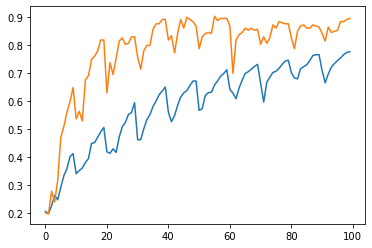

6
Sequential(
  (Liear1): Linear(in_features=9216, out_features=4096, bias=True)
  (ReLU1): ReLU(inplace=True)
  (Dropout_pool): Dropout(p=0.25, inplace=False)
  (Linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (ReLU2): ReLU(inplace=True)
  (Dropout_conv): Dropout(p=0.25, inplace=False)
  (Linear3): Linear(in_features=4096, out_features=1000, bias=True)
)

Epoch : 0


Train Loss: 2.402 | Accuracy: 0.209


Test Loss: 0.000 | Accuracy: 0.197

Epoch : 1


Train Loss: 1.615 | Accuracy: 0.219


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 2


Train Loss: 1.619 | Accuracy: 0.203


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 3


Train Loss: 1.611 | Accuracy: 0.212


Test Loss: 0.000 | Accuracy: 0.197

Epoch : 4


Train Loss: 1.613 | Accuracy: 0.198


Test Loss: 0.000 | Accuracy: 0.197

Epoch : 5


Train Loss: 1.607 | Accuracy: 0.216


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 6


Train Loss: 1.605 | Accuracy: 0.214


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 7


Train Loss: 1.606 | Accuracy: 0.196


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 8


Train Loss: 1.603 | Accuracy: 0.206


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 9


Train Loss: 1.602 | Accuracy: 0.212


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 10


Train Loss: 1.614 | Accuracy: 0.190


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 11


Train Loss: 1.611 | Accuracy: 0.211


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 12


Train Loss: 1.610 | Accuracy: 0.203


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 13


Train Loss: 1.607 | Accuracy: 0.214


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 14


Train Loss: 1.604 | Accuracy: 0.210


Test Loss: 0.000 | Accuracy: 0.197

Epoch : 15


Train Loss: 1.603 | Accuracy: 0.211


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 16


Train Loss: 1.602 | Accuracy: 0.208


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 17


Train Loss: 1.602 | Accuracy: 0.205


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 18


Train Loss: 1.600 | Accuracy: 0.214


Test Loss: 0.000 | Accuracy: 0.197

Epoch : 19


Train Loss: 1.600 | Accuracy: 0.215


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 20


Train Loss: 1.606 | Accuracy: 0.199


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 21


Train Loss: 1.606 | Accuracy: 0.214


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 22


Train Loss: 1.607 | Accuracy: 0.211


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 23


Train Loss: 1.607 | Accuracy: 0.204


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 24


Train Loss: 1.603 | Accuracy: 0.209


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 25


Train Loss: 1.605 | Accuracy: 0.207


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 26


Train Loss: 1.601 | Accuracy: 0.216


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 27


Train Loss: 1.601 | Accuracy: 0.211


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 28


Train Loss: 1.601 | Accuracy: 0.208


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 29


Train Loss: 1.599 | Accuracy: 0.207


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 30


Train Loss: 1.602 | Accuracy: 0.219


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 31


Train Loss: 1.603 | Accuracy: 0.214


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 32


Train Loss: 1.604 | Accuracy: 0.210


Test Loss: 0.000 | Accuracy: 0.197

Epoch : 33


Train Loss: 1.601 | Accuracy: 0.213


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 34


Train Loss: 1.602 | Accuracy: 0.218


Test Loss: 0.000 | Accuracy: 0.197

Epoch : 35


Train Loss: 1.602 | Accuracy: 0.210


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 36


Train Loss: 1.601 | Accuracy: 0.210


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 37


Train Loss: 1.601 | Accuracy: 0.194


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 38


Train Loss: 1.600 | Accuracy: 0.214


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 39


Train Loss: 1.600 | Accuracy: 0.203


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 40


Train Loss: 1.602 | Accuracy: 0.216


Test Loss: 0.000 | Accuracy: 0.197

Epoch : 41


Train Loss: 1.604 | Accuracy: 0.206


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 42


Train Loss: 1.602 | Accuracy: 0.216


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 43


Train Loss: 1.604 | Accuracy: 0.203


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 44


Train Loss: 1.602 | Accuracy: 0.213


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 45


Train Loss: 1.600 | Accuracy: 0.208


Test Loss: 0.000 | Accuracy: 0.197

Epoch : 46


Train Loss: 1.601 | Accuracy: 0.210


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 47


Train Loss: 1.600 | Accuracy: 0.211


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 48


Train Loss: 1.599 | Accuracy: 0.216


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 49


Train Loss: 1.599 | Accuracy: 0.209


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 50


Train Loss: 1.603 | Accuracy: 0.210


Test Loss: 0.000 | Accuracy: 0.197

Epoch : 51


Train Loss: 1.603 | Accuracy: 0.216


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 52


Train Loss: 1.603 | Accuracy: 0.211


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 53


Train Loss: 1.603 | Accuracy: 0.199


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 54


Train Loss: 1.600 | Accuracy: 0.227


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 55


Train Loss: 1.601 | Accuracy: 0.216


Test Loss: 0.000 | Accuracy: 0.197

Epoch : 56


Train Loss: 1.600 | Accuracy: 0.204


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 57


Train Loss: 1.601 | Accuracy: 0.198


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 58


Train Loss: 1.600 | Accuracy: 0.199


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 59


Train Loss: 1.599 | Accuracy: 0.217


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 60


Train Loss: 1.601 | Accuracy: 0.217


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 61


Train Loss: 1.602 | Accuracy: 0.194


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 62


Train Loss: 1.601 | Accuracy: 0.205


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 63


Train Loss: 1.602 | Accuracy: 0.212


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 64


Train Loss: 1.601 | Accuracy: 0.209


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 65


Train Loss: 1.600 | Accuracy: 0.206


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 66


Train Loss: 1.600 | Accuracy: 0.213


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 67


Train Loss: 1.600 | Accuracy: 0.220


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 68


Train Loss: 1.599 | Accuracy: 0.217


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 69


Train Loss: 1.599 | Accuracy: 0.197


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 70


Train Loss: 1.602 | Accuracy: 0.206


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 71


Train Loss: 1.601 | Accuracy: 0.207


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 72


Train Loss: 1.601 | Accuracy: 0.213


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 73


Train Loss: 1.602 | Accuracy: 0.209


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 74


Train Loss: 1.600 | Accuracy: 0.200


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 75


Train Loss: 1.600 | Accuracy: 0.210


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 76


Train Loss: 1.600 | Accuracy: 0.200


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 77


Train Loss: 1.600 | Accuracy: 0.197


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 78


Train Loss: 1.599 | Accuracy: 0.216


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 79


Train Loss: 1.599 | Accuracy: 0.221


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 80


Train Loss: 1.601 | Accuracy: 0.214


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 81


Train Loss: 1.602 | Accuracy: 0.205


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 82


Train Loss: 1.601 | Accuracy: 0.205


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 83


Train Loss: 1.601 | Accuracy: 0.210


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 84


Train Loss: 1.601 | Accuracy: 0.208


Test Loss: 0.000 | Accuracy: 0.197

Epoch : 85


Train Loss: 1.600 | Accuracy: 0.205


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 86


Train Loss: 1.600 | Accuracy: 0.209


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 87


Train Loss: 1.599 | Accuracy: 0.212


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 88


Train Loss: 1.599 | Accuracy: 0.214


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 89


Train Loss: 1.599 | Accuracy: 0.219


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 90


Train Loss: 1.600 | Accuracy: 0.208


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 91


Train Loss: 1.601 | Accuracy: 0.207


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 92


Train Loss: 1.600 | Accuracy: 0.211


Test Loss: 0.000 | Accuracy: 0.197

Epoch : 93


Train Loss: 1.600 | Accuracy: 0.206


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 94


Train Loss: 1.599 | Accuracy: 0.215


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 95


Train Loss: 1.600 | Accuracy: 0.196


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 96


Train Loss: 1.599 | Accuracy: 0.199


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 97


Train Loss: 1.600 | Accuracy: 0.207


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 98


Train Loss: 1.600 | Accuracy: 0.209


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 99


Train Loss: 1.600 | Accuracy: 0.199


Test Loss: 0.000 | Accuracy: 0.201


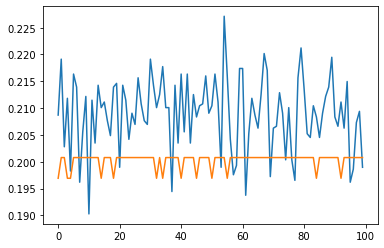

5
Sequential(
  (Dropout_flat): Dropout(p=0.25, inplace=False)
  (Liear1): Linear(in_features=9216, out_features=4096, bias=True)
  (ReLU1): ReLU(inplace=True)
  (Linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (ReLU2): ReLU(inplace=True)
  (Dropout_conv): Dropout(p=0.25, inplace=False)
  (Linear3): Linear(in_features=4096, out_features=1000, bias=True)
)

Epoch : 0


Train Loss: 2.309 | Accuracy: 0.195


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 1


Train Loss: 1.624 | Accuracy: 0.217


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 2


Train Loss: 1.619 | Accuracy: 0.212


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 3


Train Loss: 1.614 | Accuracy: 0.222


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 4


Train Loss: 1.607 | Accuracy: 0.209


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 5


Train Loss: 1.563 | Accuracy: 0.251


Test Loss: 0.000 | Accuracy: 0.355

Epoch : 6


Train Loss: 1.478 | Accuracy: 0.284


Test Loss: 0.000 | Accuracy: 0.405

Epoch : 7


Train Loss: 1.407 | Accuracy: 0.302


Test Loss: 0.000 | Accuracy: 0.432

Epoch : 8


Train Loss: 1.343 | Accuracy: 0.350


Test Loss: 0.000 | Accuracy: 0.517

Epoch : 9


Train Loss: 1.300 | Accuracy: 0.368


Test Loss: 0.000 | Accuracy: 0.529

Epoch : 10


Train Loss: 1.519 | Accuracy: 0.297


Test Loss: 0.000 | Accuracy: 0.320

Epoch : 11


Train Loss: 1.449 | Accuracy: 0.331


Test Loss: 0.000 | Accuracy: 0.444

Epoch : 12


Train Loss: 1.409 | Accuracy: 0.316


Test Loss: 0.000 | Accuracy: 0.529

Epoch : 13


Train Loss: 1.347 | Accuracy: 0.342


Test Loss: 0.000 | Accuracy: 0.479

Epoch : 14


Train Loss: 1.313 | Accuracy: 0.365


Test Loss: 0.000 | Accuracy: 0.564

Epoch : 15


Train Loss: 1.285 | Accuracy: 0.354


Test Loss: 0.000 | Accuracy: 0.598

Epoch : 16


Train Loss: 1.239 | Accuracy: 0.394


Test Loss: 0.000 | Accuracy: 0.699

Epoch : 17


Train Loss: 1.188 | Accuracy: 0.434


Test Loss: 0.000 | Accuracy: 0.710

Epoch : 18


Train Loss: 1.142 | Accuracy: 0.470


Test Loss: 0.000 | Accuracy: 0.741

Epoch : 19


Train Loss: 1.106 | Accuracy: 0.472


Test Loss: 0.000 | Accuracy: 0.757

Epoch : 20


Train Loss: 1.292 | Accuracy: 0.385


Test Loss: 0.000 | Accuracy: 0.722

Epoch : 21


Train Loss: 1.254 | Accuracy: 0.404


Test Loss: 0.000 | Accuracy: 0.610

Epoch : 22


Train Loss: 1.179 | Accuracy: 0.432


Test Loss: 0.000 | Accuracy: 0.761

Epoch : 23


Train Loss: 1.193 | Accuracy: 0.443


Test Loss: 0.000 | Accuracy: 0.753

Epoch : 24


Train Loss: 1.142 | Accuracy: 0.456


Test Loss: 0.000 | Accuracy: 0.799

Epoch : 25


Train Loss: 1.088 | Accuracy: 0.478


Test Loss: 0.000 | Accuracy: 0.780

Epoch : 26


Train Loss: 1.061 | Accuracy: 0.488


Test Loss: 0.000 | Accuracy: 0.834

Epoch : 27


Train Loss: 1.019 | Accuracy: 0.504


Test Loss: 0.000 | Accuracy: 0.838

Epoch : 28


Train Loss: 0.995 | Accuracy: 0.521


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 29


Train Loss: 0.978 | Accuracy: 0.523


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 30


Train Loss: 1.145 | Accuracy: 0.461


Test Loss: 0.000 | Accuracy: 0.784

Epoch : 31


Train Loss: 1.156 | Accuracy: 0.470


Test Loss: 0.000 | Accuracy: 0.672

Epoch : 32


Train Loss: 1.140 | Accuracy: 0.475


Test Loss: 0.000 | Accuracy: 0.795

Epoch : 33


Train Loss: 1.083 | Accuracy: 0.488


Test Loss: 0.000 | Accuracy: 0.803

Epoch : 34


Train Loss: 1.055 | Accuracy: 0.502


Test Loss: 0.000 | Accuracy: 0.737

Epoch : 35


Train Loss: 1.017 | Accuracy: 0.509


Test Loss: 0.000 | Accuracy: 0.826

Epoch : 36


Train Loss: 0.971 | Accuracy: 0.534


Test Loss: 0.000 | Accuracy: 0.819

Epoch : 37


Train Loss: 0.945 | Accuracy: 0.548


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 38


Train Loss: 0.925 | Accuracy: 0.550


Test Loss: 0.000 | Accuracy: 0.838

Epoch : 39


Train Loss: 0.897 | Accuracy: 0.574


Test Loss: 0.000 | Accuracy: 0.846

Epoch : 40


Train Loss: 1.103 | Accuracy: 0.489


Test Loss: 0.000 | Accuracy: 0.788

Epoch : 41


Train Loss: 1.131 | Accuracy: 0.484


Test Loss: 0.000 | Accuracy: 0.764

Epoch : 42


Train Loss: 1.120 | Accuracy: 0.483


Test Loss: 0.000 | Accuracy: 0.737

Epoch : 43


Train Loss: 1.082 | Accuracy: 0.497


Test Loss: 0.000 | Accuracy: 0.757

Epoch : 44


Train Loss: 1.018 | Accuracy: 0.517


Test Loss: 0.000 | Accuracy: 0.803

Epoch : 45


Train Loss: 0.959 | Accuracy: 0.541


Test Loss: 0.000 | Accuracy: 0.830

Epoch : 46


Train Loss: 0.921 | Accuracy: 0.552


Test Loss: 0.000 | Accuracy: 0.826

Epoch : 47


Train Loss: 0.897 | Accuracy: 0.577


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 48


Train Loss: 0.909 | Accuracy: 0.564


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 49


Train Loss: 0.888 | Accuracy: 0.577


Test Loss: 0.000 | Accuracy: 0.842

Epoch : 50


Train Loss: 1.005 | Accuracy: 0.537


Test Loss: 0.000 | Accuracy: 0.784

Epoch : 51


Train Loss: 1.080 | Accuracy: 0.503


Test Loss: 0.000 | Accuracy: 0.784

Epoch : 52


Train Loss: 1.045 | Accuracy: 0.509


Test Loss: 0.000 | Accuracy: 0.811

Epoch : 53


Train Loss: 1.004 | Accuracy: 0.518


Test Loss: 0.000 | Accuracy: 0.822

Epoch : 54


Train Loss: 1.013 | Accuracy: 0.520


Test Loss: 0.000 | Accuracy: 0.822

Epoch : 55


Train Loss: 0.966 | Accuracy: 0.535


Test Loss: 0.000 | Accuracy: 0.799

Epoch : 56


Train Loss: 0.926 | Accuracy: 0.548


Test Loss: 0.000 | Accuracy: 0.830

Epoch : 57


Train Loss: 0.910 | Accuracy: 0.553


Test Loss: 0.000 | Accuracy: 0.826

Epoch : 58


Train Loss: 0.901 | Accuracy: 0.558


Test Loss: 0.000 | Accuracy: 0.834

Epoch : 59


Train Loss: 0.895 | Accuracy: 0.561


Test Loss: 0.000 | Accuracy: 0.834

Epoch : 60


Train Loss: 1.031 | Accuracy: 0.525


Test Loss: 0.000 | Accuracy: 0.641

Epoch : 61


Train Loss: 1.130 | Accuracy: 0.472


Test Loss: 0.000 | Accuracy: 0.761

Epoch : 62


Train Loss: 1.052 | Accuracy: 0.500


Test Loss: 0.000 | Accuracy: 0.792

Epoch : 63


Train Loss: 1.018 | Accuracy: 0.518


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 64


Train Loss: 0.950 | Accuracy: 0.539


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 65


Train Loss: 0.940 | Accuracy: 0.539


Test Loss: 0.000 | Accuracy: 0.869

Epoch : 66


Train Loss: 0.919 | Accuracy: 0.547


Test Loss: 0.000 | Accuracy: 0.865

Epoch : 67


Train Loss: 0.911 | Accuracy: 0.548


Test Loss: 0.000 | Accuracy: 0.861

Epoch : 68


Train Loss: 0.902 | Accuracy: 0.556


Test Loss: 0.000 | Accuracy: 0.857

Epoch : 69


Train Loss: 0.901 | Accuracy: 0.554


Test Loss: 0.000 | Accuracy: 0.857

Epoch : 70


Train Loss: 0.953 | Accuracy: 0.542


Test Loss: 0.000 | Accuracy: 0.822

Epoch : 71


Train Loss: 1.058 | Accuracy: 0.508


Test Loss: 0.000 | Accuracy: 0.792

Epoch : 72


Train Loss: 1.016 | Accuracy: 0.514


Test Loss: 0.000 | Accuracy: 0.830

Epoch : 73


Train Loss: 0.976 | Accuracy: 0.531


Test Loss: 0.000 | Accuracy: 0.815

Epoch : 74


Train Loss: 0.950 | Accuracy: 0.539


Test Loss: 0.000 | Accuracy: 0.826

Epoch : 75


Train Loss: 0.916 | Accuracy: 0.554


Test Loss: 0.000 | Accuracy: 0.819

Epoch : 76


Train Loss: 0.903 | Accuracy: 0.549


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 77


Train Loss: 0.890 | Accuracy: 0.565


Test Loss: 0.000 | Accuracy: 0.846

Epoch : 78


Train Loss: 0.883 | Accuracy: 0.562


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 79


Train Loss: 0.880 | Accuracy: 0.563


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 80


Train Loss: 0.920 | Accuracy: 0.541


Test Loss: 0.000 | Accuracy: 0.768

Epoch : 81


Train Loss: 1.089 | Accuracy: 0.505


Test Loss: 0.000 | Accuracy: 0.761

Epoch : 82


Train Loss: 1.157 | Accuracy: 0.479


Test Loss: 0.000 | Accuracy: 0.761

Epoch : 83


Train Loss: 0.985 | Accuracy: 0.521


Test Loss: 0.000 | Accuracy: 0.807

Epoch : 84


Train Loss: 1.032 | Accuracy: 0.511


Test Loss: 0.000 | Accuracy: 0.811

Epoch : 85


Train Loss: 0.925 | Accuracy: 0.548


Test Loss: 0.000 | Accuracy: 0.846

Epoch : 86


Train Loss: 0.908 | Accuracy: 0.545


Test Loss: 0.000 | Accuracy: 0.842

Epoch : 87


Train Loss: 0.890 | Accuracy: 0.559


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 88


Train Loss: 0.886 | Accuracy: 0.563


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 89


Train Loss: 0.880 | Accuracy: 0.565


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 90


Train Loss: 0.934 | Accuracy: 0.548


Test Loss: 0.000 | Accuracy: 0.826

Epoch : 91


Train Loss: 0.976 | Accuracy: 0.542


Test Loss: 0.000 | Accuracy: 0.815

Epoch : 92


Train Loss: 0.958 | Accuracy: 0.543


Test Loss: 0.000 | Accuracy: 0.799

Epoch : 93


Train Loss: 0.916 | Accuracy: 0.552


Test Loss: 0.000 | Accuracy: 0.811

Epoch : 94


Train Loss: 0.937 | Accuracy: 0.546


Test Loss: 0.000 | Accuracy: 0.822

Epoch : 95


Train Loss: 0.906 | Accuracy: 0.561


Test Loss: 0.000 | Accuracy: 0.838

Epoch : 96


Train Loss: 0.884 | Accuracy: 0.572


Test Loss: 0.000 | Accuracy: 0.830

Epoch : 97


Train Loss: 0.877 | Accuracy: 0.570


Test Loss: 0.000 | Accuracy: 0.834

Epoch : 98


Train Loss: 0.874 | Accuracy: 0.575


Test Loss: 0.000 | Accuracy: 0.838

Epoch : 99


Train Loss: 0.873 | Accuracy: 0.576


Test Loss: 0.000 | Accuracy: 0.838


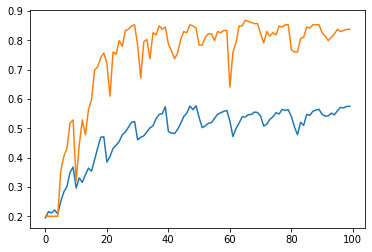

4
Sequential(
  (Liear1): Linear(in_features=9216, out_features=4096, bias=True)
  (ReLU1): ReLU(inplace=True)
  (Linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (ReLU2): ReLU(inplace=True)
  (Dropout_conv): Dropout(p=0.25, inplace=False)
  (Linear3): Linear(in_features=4096, out_features=1000, bias=True)
)

Epoch : 0


Train Loss: 2.055 | Accuracy: 0.202


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 1


Train Loss: 1.618 | Accuracy: 0.223


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 2


Train Loss: 1.614 | Accuracy: 0.207


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 3


Train Loss: 1.584 | Accuracy: 0.226


Test Loss: 0.000 | Accuracy: 0.336

Epoch : 4


Train Loss: 1.581 | Accuracy: 0.240


Test Loss: 0.000 | Accuracy: 0.332

Epoch : 5


Train Loss: 1.547 | Accuracy: 0.246


Test Loss: 0.000 | Accuracy: 0.328

Epoch : 6


Train Loss: 1.490 | Accuracy: 0.279


Test Loss: 0.000 | Accuracy: 0.398

Epoch : 7


Train Loss: 1.395 | Accuracy: 0.327


Test Loss: 0.000 | Accuracy: 0.525

Epoch : 8


Train Loss: 1.312 | Accuracy: 0.379


Test Loss: 0.000 | Accuracy: 0.703

Epoch : 9


Train Loss: 1.253 | Accuracy: 0.404


Test Loss: 0.000 | Accuracy: 0.695

Epoch : 10


Train Loss: 1.564 | Accuracy: 0.265


Test Loss: 0.000 | Accuracy: 0.336

Epoch : 11


Train Loss: 1.478 | Accuracy: 0.302


Test Loss: 0.000 | Accuracy: 0.328

Epoch : 12


Train Loss: 1.427 | Accuracy: 0.314


Test Loss: 0.000 | Accuracy: 0.463

Epoch : 13


Train Loss: 1.524 | Accuracy: 0.302


Test Loss: 0.000 | Accuracy: 0.432

Epoch : 14


Train Loss: 1.456 | Accuracy: 0.316


Test Loss: 0.000 | Accuracy: 0.517

Epoch : 15


Train Loss: 1.334 | Accuracy: 0.352


Test Loss: 0.000 | Accuracy: 0.560

Epoch : 16


Train Loss: 1.275 | Accuracy: 0.386


Test Loss: 0.000 | Accuracy: 0.672

Epoch : 17


Train Loss: 1.221 | Accuracy: 0.416


Test Loss: 0.000 | Accuracy: 0.710

Epoch : 18


Train Loss: 1.180 | Accuracy: 0.443


Test Loss: 0.000 | Accuracy: 0.703

Epoch : 19


Train Loss: 1.148 | Accuracy: 0.451


Test Loss: 0.000 | Accuracy: 0.703

Epoch : 20


Train Loss: 1.333 | Accuracy: 0.378


Test Loss: 0.000 | Accuracy: 0.571

Epoch : 21


Train Loss: 1.279 | Accuracy: 0.398


Test Loss: 0.000 | Accuracy: 0.668

Epoch : 22


Train Loss: 1.220 | Accuracy: 0.411


Test Loss: 0.000 | Accuracy: 0.668

Epoch : 23


Train Loss: 1.206 | Accuracy: 0.424


Test Loss: 0.000 | Accuracy: 0.691

Epoch : 24


Train Loss: 1.162 | Accuracy: 0.437


Test Loss: 0.000 | Accuracy: 0.718

Epoch : 25


Train Loss: 1.129 | Accuracy: 0.450


Test Loss: 0.000 | Accuracy: 0.737

Epoch : 26


Train Loss: 1.109 | Accuracy: 0.449


Test Loss: 0.000 | Accuracy: 0.772

Epoch : 27


Train Loss: 1.090 | Accuracy: 0.465


Test Loss: 0.000 | Accuracy: 0.768

Epoch : 28


Train Loss: 1.057 | Accuracy: 0.489


Test Loss: 0.000 | Accuracy: 0.795

Epoch : 29


Train Loss: 1.043 | Accuracy: 0.489


Test Loss: 0.000 | Accuracy: 0.795

Epoch : 30


Train Loss: 1.648 | Accuracy: 0.260


Test Loss: 0.000 | Accuracy: 0.220

Epoch : 31


Train Loss: 1.608 | Accuracy: 0.211


Test Loss: 0.000 | Accuracy: 0.216

Epoch : 32


Train Loss: 1.602 | Accuracy: 0.216


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 33


Train Loss: 1.600 | Accuracy: 0.223


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 34


Train Loss: 1.595 | Accuracy: 0.217


Test Loss: 0.000 | Accuracy: 0.255

Epoch : 35


Train Loss: 1.590 | Accuracy: 0.231


Test Loss: 0.000 | Accuracy: 0.270

Epoch : 36


Train Loss: 1.565 | Accuracy: 0.241


Test Loss: 0.000 | Accuracy: 0.355

Epoch : 37


Train Loss: 1.534 | Accuracy: 0.255


Test Loss: 0.000 | Accuracy: 0.340

Epoch : 38


Train Loss: 1.511 | Accuracy: 0.256


Test Loss: 0.000 | Accuracy: 0.371

Epoch : 39


Train Loss: 1.498 | Accuracy: 0.271


Test Loss: 0.000 | Accuracy: 0.398

Epoch : 40


Train Loss: 1.569 | Accuracy: 0.255


Test Loss: 0.000 | Accuracy: 0.375

Epoch : 41


Train Loss: 1.509 | Accuracy: 0.271


Test Loss: 0.000 | Accuracy: 0.386

Epoch : 42


Train Loss: 1.423 | Accuracy: 0.312


Test Loss: 0.000 | Accuracy: 0.378

Epoch : 43


Train Loss: 1.380 | Accuracy: 0.336


Test Loss: 0.000 | Accuracy: 0.575

Epoch : 44


Train Loss: 1.311 | Accuracy: 0.367


Test Loss: 0.000 | Accuracy: 0.691

Epoch : 45


Train Loss: 1.236 | Accuracy: 0.413


Test Loss: 0.000 | Accuracy: 0.676

Epoch : 46


Train Loss: 1.206 | Accuracy: 0.435


Test Loss: 0.000 | Accuracy: 0.741

Epoch : 47


Train Loss: 1.155 | Accuracy: 0.465


Test Loss: 0.000 | Accuracy: 0.734

Epoch : 48


Train Loss: 1.111 | Accuracy: 0.490


Test Loss: 0.000 | Accuracy: 0.799

Epoch : 49


Train Loss: 1.078 | Accuracy: 0.502


Test Loss: 0.000 | Accuracy: 0.807

Epoch : 50


Train Loss: 1.267 | Accuracy: 0.399


Test Loss: 0.000 | Accuracy: 0.649

Epoch : 51


Train Loss: 1.229 | Accuracy: 0.421


Test Loss: 0.000 | Accuracy: 0.745

Epoch : 52


Train Loss: 1.178 | Accuracy: 0.453


Test Loss: 0.000 | Accuracy: 0.757

Epoch : 53


Train Loss: 1.146 | Accuracy: 0.456


Test Loss: 0.000 | Accuracy: 0.764

Epoch : 54


Train Loss: 1.096 | Accuracy: 0.491


Test Loss: 0.000 | Accuracy: 0.788

Epoch : 55


Train Loss: 1.048 | Accuracy: 0.505


Test Loss: 0.000 | Accuracy: 0.815

Epoch : 56


Train Loss: 1.024 | Accuracy: 0.520


Test Loss: 0.000 | Accuracy: 0.834

Epoch : 57


Train Loss: 0.970 | Accuracy: 0.551


Test Loss: 0.000 | Accuracy: 0.819

Epoch : 58


Train Loss: 0.934 | Accuracy: 0.579


Test Loss: 0.000 | Accuracy: 0.815

Epoch : 59


Train Loss: 0.899 | Accuracy: 0.589


Test Loss: 0.000 | Accuracy: 0.807

Epoch : 60


Train Loss: 1.134 | Accuracy: 0.485


Test Loss: 0.000 | Accuracy: 0.764

Epoch : 61


Train Loss: 1.099 | Accuracy: 0.497


Test Loss: 0.000 | Accuracy: 0.795

Epoch : 62


Train Loss: 1.054 | Accuracy: 0.507


Test Loss: 0.000 | Accuracy: 0.819

Epoch : 63


Train Loss: 0.994 | Accuracy: 0.531


Test Loss: 0.000 | Accuracy: 0.799

Epoch : 64


Train Loss: 0.921 | Accuracy: 0.566


Test Loss: 0.000 | Accuracy: 0.865

Epoch : 65


Train Loss: 0.900 | Accuracy: 0.577


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 66


Train Loss: 0.837 | Accuracy: 0.600


Test Loss: 0.000 | Accuracy: 0.857

Epoch : 67


Train Loss: 0.801 | Accuracy: 0.619


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 68


Train Loss: 0.778 | Accuracy: 0.626


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 69


Train Loss: 0.758 | Accuracy: 0.642


Test Loss: 0.000 | Accuracy: 0.857

Epoch : 70


Train Loss: 1.048 | Accuracy: 0.533


Test Loss: 0.000 | Accuracy: 0.776

Epoch : 71


Train Loss: 1.002 | Accuracy: 0.547


Test Loss: 0.000 | Accuracy: 0.811

Epoch : 72


Train Loss: 0.919 | Accuracy: 0.568


Test Loss: 0.000 | Accuracy: 0.846

Epoch : 73


Train Loss: 0.909 | Accuracy: 0.570


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 74


Train Loss: 0.820 | Accuracy: 0.607


Test Loss: 0.000 | Accuracy: 0.876

Epoch : 75


Train Loss: 0.792 | Accuracy: 0.616


Test Loss: 0.000 | Accuracy: 0.846

Epoch : 76


Train Loss: 0.750 | Accuracy: 0.644


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 77


Train Loss: 0.730 | Accuracy: 0.653


Test Loss: 0.000 | Accuracy: 0.869

Epoch : 78


Train Loss: 0.702 | Accuracy: 0.661


Test Loss: 0.000 | Accuracy: 0.896

Epoch : 79


Train Loss: 0.681 | Accuracy: 0.679


Test Loss: 0.000 | Accuracy: 0.888

Epoch : 80


Train Loss: 0.884 | Accuracy: 0.588


Test Loss: 0.000 | Accuracy: 0.834

Epoch : 81


Train Loss: 0.873 | Accuracy: 0.595


Test Loss: 0.000 | Accuracy: 0.822

Epoch : 82


Train Loss: 0.818 | Accuracy: 0.615


Test Loss: 0.000 | Accuracy: 0.842

Epoch : 83


Train Loss: 0.798 | Accuracy: 0.624


Test Loss: 0.000 | Accuracy: 0.784

Epoch : 84


Train Loss: 0.782 | Accuracy: 0.634


Test Loss: 0.000 | Accuracy: 0.846

Epoch : 85


Train Loss: 0.746 | Accuracy: 0.650


Test Loss: 0.000 | Accuracy: 0.888

Epoch : 86


Train Loss: 0.685 | Accuracy: 0.669


Test Loss: 0.000 | Accuracy: 0.880

Epoch : 87


Train Loss: 0.661 | Accuracy: 0.687


Test Loss: 0.000 | Accuracy: 0.896

Epoch : 88


Train Loss: 0.645 | Accuracy: 0.698


Test Loss: 0.000 | Accuracy: 0.896

Epoch : 89


Train Loss: 0.632 | Accuracy: 0.698


Test Loss: 0.000 | Accuracy: 0.896

Epoch : 90


Train Loss: 0.843 | Accuracy: 0.618


Test Loss: 0.000 | Accuracy: 0.695

Epoch : 91


Train Loss: 0.901 | Accuracy: 0.595


Test Loss: 0.000 | Accuracy: 0.834

Epoch : 92


Train Loss: 0.765 | Accuracy: 0.642


Test Loss: 0.000 | Accuracy: 0.807

Epoch : 93


Train Loss: 0.824 | Accuracy: 0.614


Test Loss: 0.000 | Accuracy: 0.803

Epoch : 94


Train Loss: 0.717 | Accuracy: 0.669


Test Loss: 0.000 | Accuracy: 0.865

Epoch : 95


Train Loss: 0.672 | Accuracy: 0.682


Test Loss: 0.000 | Accuracy: 0.888

Epoch : 96


Train Loss: 0.650 | Accuracy: 0.687


Test Loss: 0.000 | Accuracy: 0.892

Epoch : 97


Train Loss: 0.613 | Accuracy: 0.713


Test Loss: 0.000 | Accuracy: 0.911

Epoch : 98


Train Loss: 0.591 | Accuracy: 0.726


Test Loss: 0.000 | Accuracy: 0.911

Epoch : 99


Train Loss: 0.579 | Accuracy: 0.738


Test Loss: 0.000 | Accuracy: 0.915


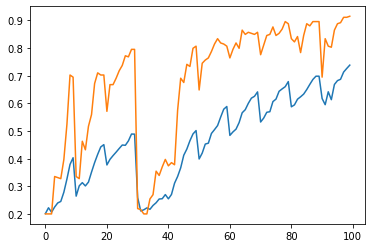

3
Sequential(
  (Dropout_flat): Dropout(p=0.25, inplace=False)
  (Liear1): Linear(in_features=9216, out_features=4096, bias=True)
  (ReLU1): ReLU(inplace=True)
  (Dropout_pool): Dropout(p=0.25, inplace=False)
  (Linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (ReLU2): ReLU(inplace=True)
  (Linear3): Linear(in_features=4096, out_features=1000, bias=True)
)

Epoch : 0


Train Loss: 2.201 | Accuracy: 0.218


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 1


Train Loss: 1.622 | Accuracy: 0.209


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 2


Train Loss: 1.616 | Accuracy: 0.205


Test Loss: 0.000 | Accuracy: 0.197

Epoch : 3


Train Loss: 1.599 | Accuracy: 0.218


Test Loss: 0.000 | Accuracy: 0.170

Epoch : 4


Train Loss: 1.544 | Accuracy: 0.243


Test Loss: 0.000 | Accuracy: 0.282

Epoch : 5


Train Loss: 1.498 | Accuracy: 0.268


Test Loss: 0.000 | Accuracy: 0.363

Epoch : 6


Train Loss: 1.455 | Accuracy: 0.280


Test Loss: 0.000 | Accuracy: 0.320

Epoch : 7


Train Loss: 1.411 | Accuracy: 0.297


Test Loss: 0.000 | Accuracy: 0.467

Epoch : 8


Train Loss: 1.355 | Accuracy: 0.336


Test Loss: 0.000 | Accuracy: 0.456

Epoch : 9


Train Loss: 1.306 | Accuracy: 0.375


Test Loss: 0.000 | Accuracy: 0.602

Epoch : 10


Train Loss: 1.483 | Accuracy: 0.278


Test Loss: 0.000 | Accuracy: 0.459

Epoch : 11


Train Loss: 1.410 | Accuracy: 0.326


Test Loss: 0.000 | Accuracy: 0.583

Epoch : 12


Train Loss: 1.346 | Accuracy: 0.359


Test Loss: 0.000 | Accuracy: 0.591

Epoch : 13


Train Loss: 1.325 | Accuracy: 0.377


Test Loss: 0.000 | Accuracy: 0.695

Epoch : 14


Train Loss: 1.252 | Accuracy: 0.397


Test Loss: 0.000 | Accuracy: 0.668

Epoch : 15


Train Loss: 1.212 | Accuracy: 0.409


Test Loss: 0.000 | Accuracy: 0.699

Epoch : 16


Train Loss: 1.171 | Accuracy: 0.420


Test Loss: 0.000 | Accuracy: 0.710

Epoch : 17


Train Loss: 1.122 | Accuracy: 0.448


Test Loss: 0.000 | Accuracy: 0.734

Epoch : 18


Train Loss: 1.076 | Accuracy: 0.472


Test Loss: 0.000 | Accuracy: 0.772

Epoch : 19


Train Loss: 1.048 | Accuracy: 0.492


Test Loss: 0.000 | Accuracy: 0.799

Epoch : 20


Train Loss: 1.241 | Accuracy: 0.411


Test Loss: 0.000 | Accuracy: 0.710

Epoch : 21


Train Loss: 1.206 | Accuracy: 0.424


Test Loss: 0.000 | Accuracy: 0.668

Epoch : 22


Train Loss: 1.198 | Accuracy: 0.431


Test Loss: 0.000 | Accuracy: 0.768

Epoch : 23


Train Loss: 1.208 | Accuracy: 0.438


Test Loss: 0.000 | Accuracy: 0.695

Epoch : 24


Train Loss: 1.185 | Accuracy: 0.436


Test Loss: 0.000 | Accuracy: 0.764

Epoch : 25


Train Loss: 1.119 | Accuracy: 0.469


Test Loss: 0.000 | Accuracy: 0.749

Epoch : 26


Train Loss: 1.053 | Accuracy: 0.504


Test Loss: 0.000 | Accuracy: 0.826

Epoch : 27


Train Loss: 0.999 | Accuracy: 0.539


Test Loss: 0.000 | Accuracy: 0.795

Epoch : 28


Train Loss: 0.946 | Accuracy: 0.563


Test Loss: 0.000 | Accuracy: 0.834

Epoch : 29


Train Loss: 0.912 | Accuracy: 0.586


Test Loss: 0.000 | Accuracy: 0.822

Epoch : 30


Train Loss: 1.156 | Accuracy: 0.465


Test Loss: 0.000 | Accuracy: 0.780

Epoch : 31


Train Loss: 1.088 | Accuracy: 0.481


Test Loss: 0.000 | Accuracy: 0.803

Epoch : 32


Train Loss: 1.084 | Accuracy: 0.503


Test Loss: 0.000 | Accuracy: 0.653

Epoch : 33


Train Loss: 1.142 | Accuracy: 0.482


Test Loss: 0.000 | Accuracy: 0.795

Epoch : 34


Train Loss: 1.018 | Accuracy: 0.521


Test Loss: 0.000 | Accuracy: 0.757

Epoch : 35


Train Loss: 0.931 | Accuracy: 0.566


Test Loss: 0.000 | Accuracy: 0.834

Epoch : 36


Train Loss: 0.898 | Accuracy: 0.580


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 37


Train Loss: 0.836 | Accuracy: 0.605


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 38


Train Loss: 0.804 | Accuracy: 0.625


Test Loss: 0.000 | Accuracy: 0.842

Epoch : 39


Train Loss: 0.790 | Accuracy: 0.627


Test Loss: 0.000 | Accuracy: 0.842

Epoch : 40


Train Loss: 0.998 | Accuracy: 0.547


Test Loss: 0.000 | Accuracy: 0.819

Epoch : 41


Train Loss: 0.981 | Accuracy: 0.546


Test Loss: 0.000 | Accuracy: 0.788

Epoch : 42


Train Loss: 0.955 | Accuracy: 0.556


Test Loss: 0.000 | Accuracy: 0.815

Epoch : 43


Train Loss: 0.916 | Accuracy: 0.575


Test Loss: 0.000 | Accuracy: 0.846

Epoch : 44


Train Loss: 0.895 | Accuracy: 0.587


Test Loss: 0.000 | Accuracy: 0.826

Epoch : 45


Train Loss: 0.818 | Accuracy: 0.607


Test Loss: 0.000 | Accuracy: 0.861

Epoch : 46


Train Loss: 0.801 | Accuracy: 0.618


Test Loss: 0.000 | Accuracy: 0.865

Epoch : 47


Train Loss: 0.781 | Accuracy: 0.626


Test Loss: 0.000 | Accuracy: 0.873

Epoch : 48


Train Loss: 0.760 | Accuracy: 0.640


Test Loss: 0.000 | Accuracy: 0.861

Epoch : 49


Train Loss: 0.754 | Accuracy: 0.642


Test Loss: 0.000 | Accuracy: 0.873

Epoch : 50


Train Loss: 0.949 | Accuracy: 0.559


Test Loss: 0.000 | Accuracy: 0.788

Epoch : 51


Train Loss: 0.986 | Accuracy: 0.568


Test Loss: 0.000 | Accuracy: 0.768

Epoch : 52


Train Loss: 0.922 | Accuracy: 0.576


Test Loss: 0.000 | Accuracy: 0.846

Epoch : 53


Train Loss: 0.901 | Accuracy: 0.586


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 54


Train Loss: 0.843 | Accuracy: 0.603


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 55


Train Loss: 0.803 | Accuracy: 0.629


Test Loss: 0.000 | Accuracy: 0.842

Epoch : 56


Train Loss: 0.768 | Accuracy: 0.641


Test Loss: 0.000 | Accuracy: 0.830

Epoch : 57


Train Loss: 0.749 | Accuracy: 0.644


Test Loss: 0.000 | Accuracy: 0.873

Epoch : 58


Train Loss: 0.728 | Accuracy: 0.652


Test Loss: 0.000 | Accuracy: 0.865

Epoch : 59


Train Loss: 0.722 | Accuracy: 0.657


Test Loss: 0.000 | Accuracy: 0.876

Epoch : 60


Train Loss: 0.995 | Accuracy: 0.562


Test Loss: 0.000 | Accuracy: 0.776

Epoch : 61


Train Loss: 0.972 | Accuracy: 0.560


Test Loss: 0.000 | Accuracy: 0.641

Epoch : 62


Train Loss: 0.899 | Accuracy: 0.588


Test Loss: 0.000 | Accuracy: 0.784

Epoch : 63


Train Loss: 0.908 | Accuracy: 0.595


Test Loss: 0.000 | Accuracy: 0.788

Epoch : 64


Train Loss: 0.839 | Accuracy: 0.609


Test Loss: 0.000 | Accuracy: 0.803

Epoch : 65


Train Loss: 0.822 | Accuracy: 0.622


Test Loss: 0.000 | Accuracy: 0.846

Epoch : 66


Train Loss: 0.776 | Accuracy: 0.620


Test Loss: 0.000 | Accuracy: 0.842

Epoch : 67


Train Loss: 0.745 | Accuracy: 0.648


Test Loss: 0.000 | Accuracy: 0.846

Epoch : 68


Train Loss: 0.733 | Accuracy: 0.658


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 69


Train Loss: 0.714 | Accuracy: 0.664


Test Loss: 0.000 | Accuracy: 0.857

Epoch : 70


Train Loss: 0.820 | Accuracy: 0.609


Test Loss: 0.000 | Accuracy: 0.838

Epoch : 71


Train Loss: 0.960 | Accuracy: 0.583


Test Loss: 0.000 | Accuracy: 0.811

Epoch : 72


Train Loss: 0.813 | Accuracy: 0.619


Test Loss: 0.000 | Accuracy: 0.788

Epoch : 73


Train Loss: 0.795 | Accuracy: 0.626


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 74


Train Loss: 0.805 | Accuracy: 0.622


Test Loss: 0.000 | Accuracy: 0.819

Epoch : 75


Train Loss: 0.798 | Accuracy: 0.627


Test Loss: 0.000 | Accuracy: 0.869

Epoch : 76


Train Loss: 0.760 | Accuracy: 0.637


Test Loss: 0.000 | Accuracy: 0.861

Epoch : 77


Train Loss: 0.721 | Accuracy: 0.662


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 78


Train Loss: 0.705 | Accuracy: 0.667


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 79


Train Loss: 0.692 | Accuracy: 0.674


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 80


Train Loss: 0.842 | Accuracy: 0.607


Test Loss: 0.000 | Accuracy: 0.799

Epoch : 81


Train Loss: 0.818 | Accuracy: 0.619


Test Loss: 0.000 | Accuracy: 0.764

Epoch : 82


Train Loss: 0.850 | Accuracy: 0.599


Test Loss: 0.000 | Accuracy: 0.838

Epoch : 83


Train Loss: 0.790 | Accuracy: 0.634


Test Loss: 0.000 | Accuracy: 0.861

Epoch : 84


Train Loss: 0.755 | Accuracy: 0.636


Test Loss: 0.000 | Accuracy: 0.846

Epoch : 85


Train Loss: 0.774 | Accuracy: 0.628


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 86


Train Loss: 0.720 | Accuracy: 0.652


Test Loss: 0.000 | Accuracy: 0.846

Epoch : 87


Train Loss: 0.703 | Accuracy: 0.661


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 88


Train Loss: 0.677 | Accuracy: 0.684


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 89


Train Loss: 0.669 | Accuracy: 0.692


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 90


Train Loss: 0.813 | Accuracy: 0.624


Test Loss: 0.000 | Accuracy: 0.749

Epoch : 91


Train Loss: 0.903 | Accuracy: 0.578


Test Loss: 0.000 | Accuracy: 0.815

Epoch : 92


Train Loss: 0.819 | Accuracy: 0.611


Test Loss: 0.000 | Accuracy: 0.807

Epoch : 93


Train Loss: 0.760 | Accuracy: 0.649


Test Loss: 0.000 | Accuracy: 0.846

Epoch : 94


Train Loss: 0.722 | Accuracy: 0.659


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 95


Train Loss: 0.714 | Accuracy: 0.669


Test Loss: 0.000 | Accuracy: 0.865

Epoch : 96


Train Loss: 0.684 | Accuracy: 0.679


Test Loss: 0.000 | Accuracy: 0.846

Epoch : 97


Train Loss: 0.657 | Accuracy: 0.699


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 98


Train Loss: 0.650 | Accuracy: 0.704


Test Loss: 0.000 | Accuracy: 0.846

Epoch : 99


Train Loss: 0.631 | Accuracy: 0.712


Test Loss: 0.000 | Accuracy: 0.849


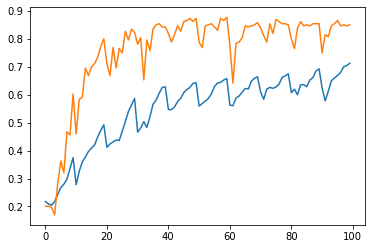

2
Sequential(
  (Liear1): Linear(in_features=9216, out_features=4096, bias=True)
  (ReLU1): ReLU(inplace=True)
  (Dropout_pool): Dropout(p=0.25, inplace=False)
  (Linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (ReLU2): ReLU(inplace=True)
  (Linear3): Linear(in_features=4096, out_features=1000, bias=True)
)

Epoch : 0


Train Loss: 2.536 | Accuracy: 0.207


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 1


Train Loss: 1.614 | Accuracy: 0.215


Test Loss: 0.000 | Accuracy: 0.201

Epoch : 2


Train Loss: 1.609 | Accuracy: 0.219


Test Loss: 0.000 | Accuracy: 0.282

Epoch : 3


Train Loss: 1.559 | Accuracy: 0.247


Test Loss: 0.000 | Accuracy: 0.324

Epoch : 4


Train Loss: 1.475 | Accuracy: 0.288


Test Loss: 0.000 | Accuracy: 0.417

Epoch : 5


Train Loss: 1.542 | Accuracy: 0.306


Test Loss: 0.000 | Accuracy: 0.305

Epoch : 6


Train Loss: 1.425 | Accuracy: 0.309


Test Loss: 0.000 | Accuracy: 0.521

Epoch : 7


Train Loss: 1.351 | Accuracy: 0.347


Test Loss: 0.000 | Accuracy: 0.463

Epoch : 8


Train Loss: 1.315 | Accuracy: 0.360


Test Loss: 0.000 | Accuracy: 0.583

Epoch : 9


Train Loss: 1.283 | Accuracy: 0.379


Test Loss: 0.000 | Accuracy: 0.571

Epoch : 10


Train Loss: 1.421 | Accuracy: 0.331


Test Loss: 0.000 | Accuracy: 0.552

Epoch : 11


Train Loss: 1.395 | Accuracy: 0.334


Test Loss: 0.000 | Accuracy: 0.533

Epoch : 12


Train Loss: 1.339 | Accuracy: 0.358


Test Loss: 0.000 | Accuracy: 0.525

Epoch : 13


Train Loss: 1.294 | Accuracy: 0.387


Test Loss: 0.000 | Accuracy: 0.625

Epoch : 14


Train Loss: 1.260 | Accuracy: 0.396


Test Loss: 0.000 | Accuracy: 0.683

Epoch : 15


Train Loss: 1.190 | Accuracy: 0.427


Test Loss: 0.000 | Accuracy: 0.734

Epoch : 16


Train Loss: 1.138 | Accuracy: 0.449


Test Loss: 0.000 | Accuracy: 0.753

Epoch : 17


Train Loss: 1.101 | Accuracy: 0.476


Test Loss: 0.000 | Accuracy: 0.788

Epoch : 18


Train Loss: 1.050 | Accuracy: 0.508


Test Loss: 0.000 | Accuracy: 0.788

Epoch : 19


Train Loss: 1.022 | Accuracy: 0.542


Test Loss: 0.000 | Accuracy: 0.803

Epoch : 20


Train Loss: 1.247 | Accuracy: 0.425


Test Loss: 0.000 | Accuracy: 0.707

Epoch : 21


Train Loss: 1.226 | Accuracy: 0.422


Test Loss: 0.000 | Accuracy: 0.726

Epoch : 22


Train Loss: 1.198 | Accuracy: 0.426


Test Loss: 0.000 | Accuracy: 0.741

Epoch : 23


Train Loss: 1.171 | Accuracy: 0.434


Test Loss: 0.000 | Accuracy: 0.745

Epoch : 24


Train Loss: 1.147 | Accuracy: 0.443


Test Loss: 0.000 | Accuracy: 0.761

Epoch : 25


Train Loss: 1.071 | Accuracy: 0.481


Test Loss: 0.000 | Accuracy: 0.772

Epoch : 26


Train Loss: 1.016 | Accuracy: 0.529


Test Loss: 0.000 | Accuracy: 0.799

Epoch : 27


Train Loss: 0.989 | Accuracy: 0.538


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 28


Train Loss: 0.923 | Accuracy: 0.570


Test Loss: 0.000 | Accuracy: 0.869

Epoch : 29


Train Loss: 0.879 | Accuracy: 0.595


Test Loss: 0.000 | Accuracy: 0.857

Epoch : 30


Train Loss: 1.156 | Accuracy: 0.458


Test Loss: 0.000 | Accuracy: 0.699

Epoch : 31


Train Loss: 1.113 | Accuracy: 0.467


Test Loss: 0.000 | Accuracy: 0.819

Epoch : 32


Train Loss: 1.105 | Accuracy: 0.483


Test Loss: 0.000 | Accuracy: 0.815

Epoch : 33


Train Loss: 1.076 | Accuracy: 0.488


Test Loss: 0.000 | Accuracy: 0.726

Epoch : 34


Train Loss: 1.063 | Accuracy: 0.510


Test Loss: 0.000 | Accuracy: 0.726

Epoch : 35


Train Loss: 0.976 | Accuracy: 0.547


Test Loss: 0.000 | Accuracy: 0.857

Epoch : 36


Train Loss: 0.902 | Accuracy: 0.577


Test Loss: 0.000 | Accuracy: 0.873

Epoch : 37


Train Loss: 0.863 | Accuracy: 0.592


Test Loss: 0.000 | Accuracy: 0.880

Epoch : 38


Train Loss: 0.821 | Accuracy: 0.617


Test Loss: 0.000 | Accuracy: 0.876

Epoch : 39


Train Loss: 0.804 | Accuracy: 0.622


Test Loss: 0.000 | Accuracy: 0.880

Epoch : 40


Train Loss: 1.104 | Accuracy: 0.502


Test Loss: 0.000 | Accuracy: 0.749

Epoch : 41


Train Loss: 1.016 | Accuracy: 0.530


Test Loss: 0.000 | Accuracy: 0.822

Epoch : 42


Train Loss: 1.021 | Accuracy: 0.542


Test Loss: 0.000 | Accuracy: 0.846

Epoch : 43


Train Loss: 0.993 | Accuracy: 0.549


Test Loss: 0.000 | Accuracy: 0.822

Epoch : 44


Train Loss: 0.924 | Accuracy: 0.568


Test Loss: 0.000 | Accuracy: 0.815

Epoch : 45


Train Loss: 0.881 | Accuracy: 0.586


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 46


Train Loss: 0.807 | Accuracy: 0.613


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 47


Train Loss: 0.785 | Accuracy: 0.635


Test Loss: 0.000 | Accuracy: 0.869

Epoch : 48


Train Loss: 0.745 | Accuracy: 0.655


Test Loss: 0.000 | Accuracy: 0.876

Epoch : 49


Train Loss: 0.729 | Accuracy: 0.655


Test Loss: 0.000 | Accuracy: 0.876

Epoch : 50


Train Loss: 0.963 | Accuracy: 0.551


Test Loss: 0.000 | Accuracy: 0.799

Epoch : 51


Train Loss: 1.082 | Accuracy: 0.522


Test Loss: 0.000 | Accuracy: 0.737

Epoch : 52


Train Loss: 0.940 | Accuracy: 0.576


Test Loss: 0.000 | Accuracy: 0.838

Epoch : 53


Train Loss: 0.871 | Accuracy: 0.591


Test Loss: 0.000 | Accuracy: 0.807

Epoch : 54


Train Loss: 0.852 | Accuracy: 0.609


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 55


Train Loss: 0.799 | Accuracy: 0.623


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 56


Train Loss: 0.765 | Accuracy: 0.643


Test Loss: 0.000 | Accuracy: 0.861

Epoch : 57


Train Loss: 0.739 | Accuracy: 0.649


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 58


Train Loss: 0.709 | Accuracy: 0.661


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 59


Train Loss: 0.693 | Accuracy: 0.672


Test Loss: 0.000 | Accuracy: 0.849

Epoch : 60


Train Loss: 0.863 | Accuracy: 0.603


Test Loss: 0.000 | Accuracy: 0.803

Epoch : 61


Train Loss: 0.896 | Accuracy: 0.590


Test Loss: 0.000 | Accuracy: 0.815

Epoch : 62


Train Loss: 0.952 | Accuracy: 0.590


Test Loss: 0.000 | Accuracy: 0.788

Epoch : 63


Train Loss: 0.877 | Accuracy: 0.595


Test Loss: 0.000 | Accuracy: 0.842

Epoch : 64


Train Loss: 0.808 | Accuracy: 0.632


Test Loss: 0.000 | Accuracy: 0.834

Epoch : 65


Train Loss: 0.756 | Accuracy: 0.649


Test Loss: 0.000 | Accuracy: 0.842

Epoch : 66


Train Loss: 0.736 | Accuracy: 0.662


Test Loss: 0.000 | Accuracy: 0.861

Epoch : 67


Train Loss: 0.688 | Accuracy: 0.681


Test Loss: 0.000 | Accuracy: 0.876

Epoch : 68


Train Loss: 0.673 | Accuracy: 0.688


Test Loss: 0.000 | Accuracy: 0.869

Epoch : 69


Train Loss: 0.657 | Accuracy: 0.697


Test Loss: 0.000 | Accuracy: 0.873

Epoch : 70


Train Loss: 0.818 | Accuracy: 0.631


Test Loss: 0.000 | Accuracy: 0.819

Epoch : 71


Train Loss: 0.817 | Accuracy: 0.629


Test Loss: 0.000 | Accuracy: 0.757

Epoch : 72


Train Loss: 0.831 | Accuracy: 0.627


Test Loss: 0.000 | Accuracy: 0.780

Epoch : 73


Train Loss: 0.822 | Accuracy: 0.616


Test Loss: 0.000 | Accuracy: 0.857

Epoch : 74


Train Loss: 0.743 | Accuracy: 0.667


Test Loss: 0.000 | Accuracy: 0.838

Epoch : 75


Train Loss: 0.686 | Accuracy: 0.687


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 76


Train Loss: 0.652 | Accuracy: 0.693


Test Loss: 0.000 | Accuracy: 0.873

Epoch : 77


Train Loss: 0.615 | Accuracy: 0.710


Test Loss: 0.000 | Accuracy: 0.876

Epoch : 78


Train Loss: 0.593 | Accuracy: 0.727


Test Loss: 0.000 | Accuracy: 0.880

Epoch : 79


Train Loss: 0.577 | Accuracy: 0.732


Test Loss: 0.000 | Accuracy: 0.880

Epoch : 80


Train Loss: 0.710 | Accuracy: 0.670


Test Loss: 0.000 | Accuracy: 0.846

Epoch : 81


Train Loss: 0.734 | Accuracy: 0.669


Test Loss: 0.000 | Accuracy: 0.826

Epoch : 82


Train Loss: 0.762 | Accuracy: 0.657


Test Loss: 0.000 | Accuracy: 0.876

Epoch : 83


Train Loss: 0.880 | Accuracy: 0.632


Test Loss: 0.000 | Accuracy: 0.815

Epoch : 84


Train Loss: 0.687 | Accuracy: 0.675


Test Loss: 0.000 | Accuracy: 0.842

Epoch : 85


Train Loss: 0.619 | Accuracy: 0.705


Test Loss: 0.000 | Accuracy: 0.884

Epoch : 86


Train Loss: 0.579 | Accuracy: 0.737


Test Loss: 0.000 | Accuracy: 0.888

Epoch : 87


Train Loss: 0.559 | Accuracy: 0.736


Test Loss: 0.000 | Accuracy: 0.888

Epoch : 88


Train Loss: 0.537 | Accuracy: 0.753


Test Loss: 0.000 | Accuracy: 0.888

Epoch : 89


Train Loss: 0.519 | Accuracy: 0.765


Test Loss: 0.000 | Accuracy: 0.892

Epoch : 90


Train Loss: 0.680 | Accuracy: 0.691


Test Loss: 0.000 | Accuracy: 0.819

Epoch : 91


Train Loss: 0.758 | Accuracy: 0.658


Test Loss: 0.000 | Accuracy: 0.819

Epoch : 92


Train Loss: 0.685 | Accuracy: 0.697


Test Loss: 0.000 | Accuracy: 0.830

Epoch : 93


Train Loss: 0.607 | Accuracy: 0.720


Test Loss: 0.000 | Accuracy: 0.865

Epoch : 94


Train Loss: 0.589 | Accuracy: 0.738


Test Loss: 0.000 | Accuracy: 0.853

Epoch : 95


Train Loss: 0.553 | Accuracy: 0.754


Test Loss: 0.000 | Accuracy: 0.865

Epoch : 96


Train Loss: 0.537 | Accuracy: 0.762


Test Loss: 0.000 | Accuracy: 0.861

Epoch : 97


Train Loss: 0.496 | Accuracy: 0.779


Test Loss: 0.000 | Accuracy: 0.865

Epoch : 98


Train Loss: 0.471 | Accuracy: 0.792


Test Loss: 0.000 | Accuracy: 0.861

Epoch : 99


Train Loss: 0.460 | Accuracy: 0.790


Test Loss: 0.000 | Accuracy: 0.861


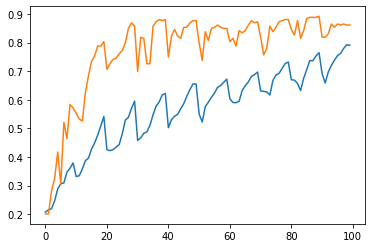

In [17]:
drop_train_loss = []
drop_train_acc = []
drop_test_loss = []
drop_test_acc = []

for i in range(7,1,-1):
  print(i)
  drop_conv, drop_pool, drop_flat = format(i,'03b')
  model = AlexNet(drop_conv=bool(int(drop_conv)), drop_pool=bool(int(drop_pool)), drop_flat=bool(int(drop_flat))).to(device)
  print(model.classifier)
  # Loss and optimizer
  criterion = nn.CrossEntropyLoss(reduction="mean")
  optimizer = torch.optim.AdamW(model.parameters(), lr=0.0009)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=0.00001)

  # Train the model
  total_step = len(train_loader)

  for epoch in range(num_epochs):
    train(epoch)
    test(epoch)
  
  plt.plot(train_acc[-100:])
  plt.plot(eval_acc[-100:])
  plt.show()

  drop_train_loss.append(train_loss[-100:])
  drop_train_acc.append(train_acc[-100:])
  drop_test_loss.append(eval_loss[-100:])
  drop_test_acc.append(eval_acc[-100:])

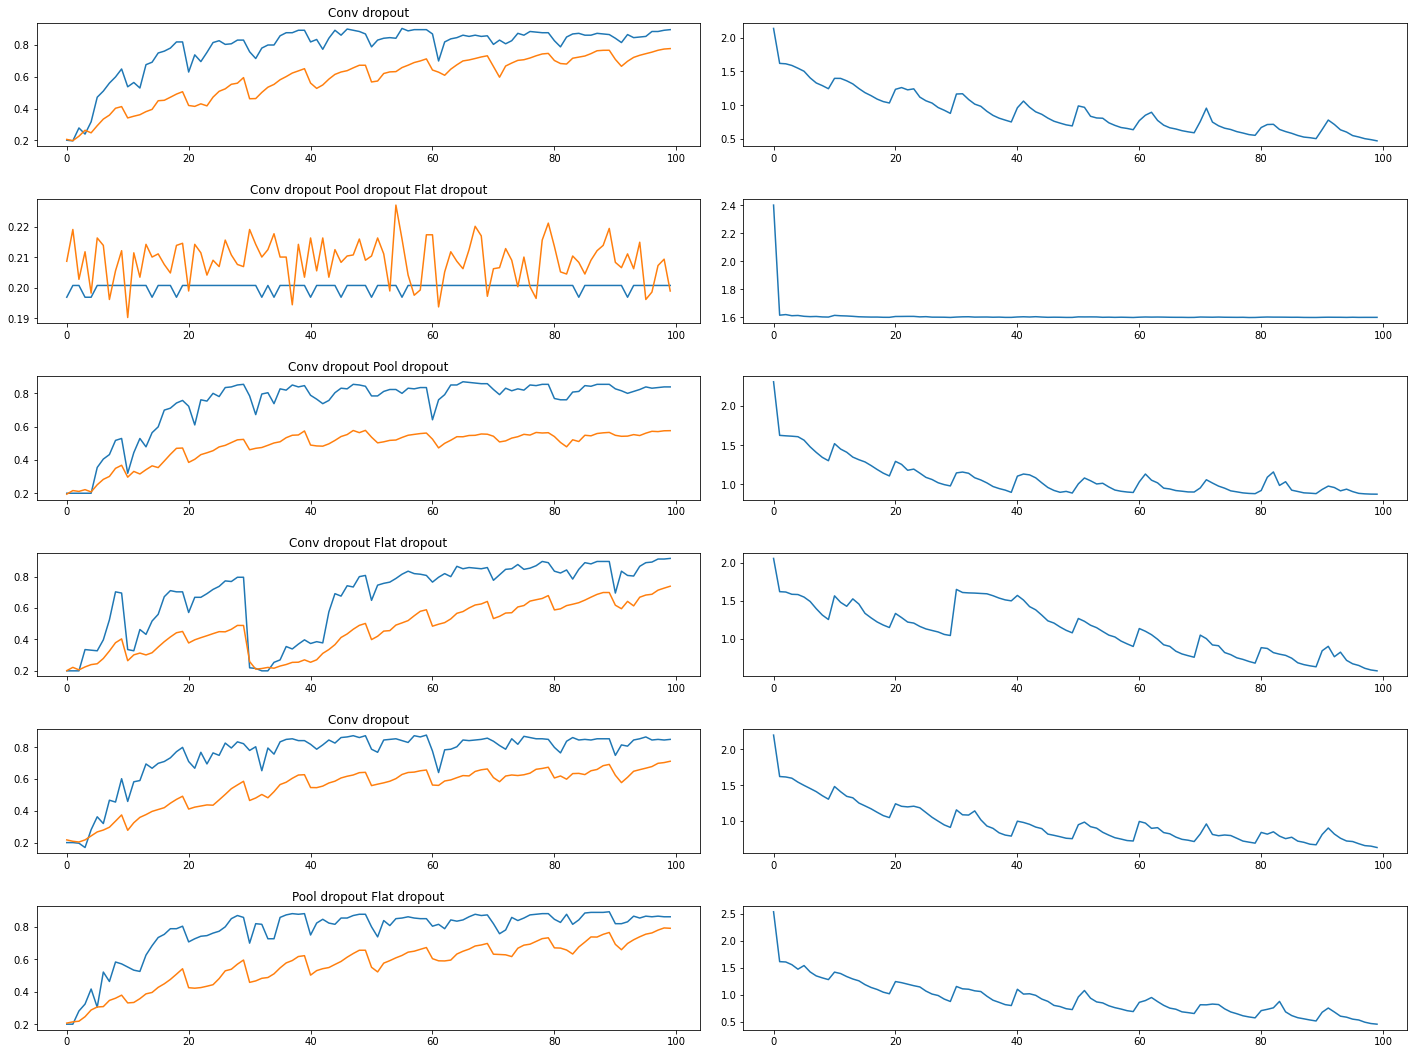

In [40]:
fig, axs = plt.subplots(6,2, figsize=(20,15))
for i, (t_a, v_a, v_l) in enumerate(zip(drop_test_acc, drop_train_acc, drop_train_loss)):
    s = format(8-i, "03b")
    t = []
    if(bool(int(s[0]))): t.append("Conv dropout")
    if(bool(int(s[1]))): t.append("Pool dropout")
    if(bool(int(s[2]))): t.append("Flat dropout")
    #Accuracy plots
    axs[i, 0].plot(t_a)
    axs[i, 0].plot(v_a)
    axs[i, 0].set_title(' '.join([str(elem) for elem in t]))
    # axs[i, 0].xlabel('epoch')
    # axs[i, 0].ylabel('accuracy')
    #Loss plots
    axs[i, 1].plot(v_l)
    # axs[i, 1].set_title("Train Loss")
    # axs[i, 1].xlabel('epoch')
    # axs[i, 1].ylabel('loss')
    

# axs[0,0].set_title("Train vs Valid Acc")

# axs[0,1].set_title("Train Loss")

fig.tight_layout(pad=2.0)
plt.show()

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
num_epochs = 100
batch_size = 64
learning_rate = 0.005

model = AlexNet().to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  


# Train the model
total_step = len(train_loader)

In [ ]:

total_step = len(train_loader)

for epoch in range(num_epochs):
    train(epoch)
    test(epoch)